## Teamgegevens
- **Teamnaam:** meow
- **Teamleden:**
  - Caitlyn - Kaggle: @caitlyncon
  - Duane - Kaggle: @duanewiegel
  - Nanssy - Kaggle: @nanssy000
  - Rayan - Kaggle: @rayrytb




## 1. Opdracht 1: Exploratieve Data Analyse
### 1.1 Data quality checks
Controleer of de data geschikt is voor machine learning door te kijken naar:
- Negatieve of onrealistische waarden
- Duplicaten
- Outliers of vreemde waardes

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
import warnings
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf

# Data inladen
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Datumtijd kolom omzetten
train['date_hour'] = pd.to_datetime(train['date_hour'])
test['date_hour'] = pd.to_datetime(test['date_hour'])

print("DATA QUALITY CHECKS")

# 1. Check voor negatieve waarden
print("\n1. Negatieve waarden check:")
print(f"   Negatieve cnt waarden: {(train['cnt'] < 0).sum()}")
print(f"   Negatieve temp waarden: {(train['temp'] < 0).sum()}")
print(f"   Negatieve hum waarden: {(train['hum'] < 0).sum()}")
print(f"   Negatieve windspeed waarden: {(train['windspeed'] < 0).sum()}")

# 2. Check voor out-of-range waarden
print("\n2. Out-of-range waarden check:")
print(f"temp > 1: {(train['temp'] > 1).sum()}")
print(f"atemp > 1: {(train['atemp'] > 1).sum()}")
print(f"hum > 1: {(train['hum'] > 1).sum()}")
print(f"windspeed > 1: {(train['windspeed'] > 1).sum()}")

# 3. Check min/max waarden
print("\n3. Min/Max waarden:")
for col in ['cnt', 'temp', 'atemp', 'hum', 'windspeed', 'holiday', 'weathersit']:
    print(f"   {col}: min={train[col].min():.4f}, max={train[col].max():.4f}")

# 4. Check voor duplicaten
print("\n4. Duplicaten check:")
duplicates_time = train['date_hour'].duplicated().sum()
duplicates_full = train.duplicated().sum()
print(f"   Dubbele timestamps: {duplicates_time}")
print(f"   Volledig dubbele rijen: {duplicates_full}")

# 5. Missende waarden
print("\n5. Missende waarden:")
missing = train.isnull().sum()
if missing.sum() == 0:
    print("Geen missende waarden gevonden!")
else:
    print(missing[missing > 0])

# 6. Check voor rare outliers in cnt
print("\n6. Outlier analyse voor 'cnt':")
Q1 = train['cnt'].quantile(0.25)
Q3 = train['cnt'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((train['cnt'] < (Q1 - 1.5 * IQR)) | (train['cnt'] > (Q3 + 1.5 * IQR))).sum()
print(f"   IQR methode: {outliers} outliers ({outliers/len(train)*100:.2f}%)")
print(f"   95th percentile: {train['cnt'].quantile(0.95):.0f}")
print(f"   99th percentile: {train['cnt'].quantile(0.99):.0f}")

DATA QUALITY CHECKS

1. Negatieve waarden check:
   Negatieve cnt waarden: 0
   Negatieve temp waarden: 0
   Negatieve hum waarden: 0
   Negatieve windspeed waarden: 0

2. Out-of-range waarden check:
temp > 1: 0
atemp > 1: 0
hum > 1: 0
windspeed > 1: 0

3. Min/Max waarden:
   cnt: min=1.0000, max=977.0000
   temp: min=0.0200, max=1.0000
   atemp: min=0.0000, max=1.0000
   hum: min=0.0000, max=1.0000
   windspeed: min=0.0000, max=0.8507
   holiday: min=0.0000, max=1.0000
   weathersit: min=1.0000, max=4.0000

4. Duplicaten check:
   Dubbele timestamps: 0
   Volledig dubbele rijen: 0

5. Missende waarden:
Geen missende waarden gevonden!

6. Outlier analyse voor 'cnt':
   IQR methode: 486 outliers (2.92%)
   95th percentile: 565
   99th percentile: 785


**Conclusie data quality:**

- Er zijn geen negatieve waarden gedetecteerd
- Alle genormaliseerde features (temp, hum, windspeed) liggen tussen 0 en 1
- Er zijn geen dubbele timestamps of rijen
- Er zijn geen missende waarden in de dataset
- Outliers in 'cnt' zijn juist (piekuren, feestdagen, mooi weer)
- Hierdoor is deze data geschikt voor machine learning zonder verdere cleaning

### 1.2 Distributies van numerieke variabelen
Histogrammen om de verdeling van belangrijke variabelen te bekijken

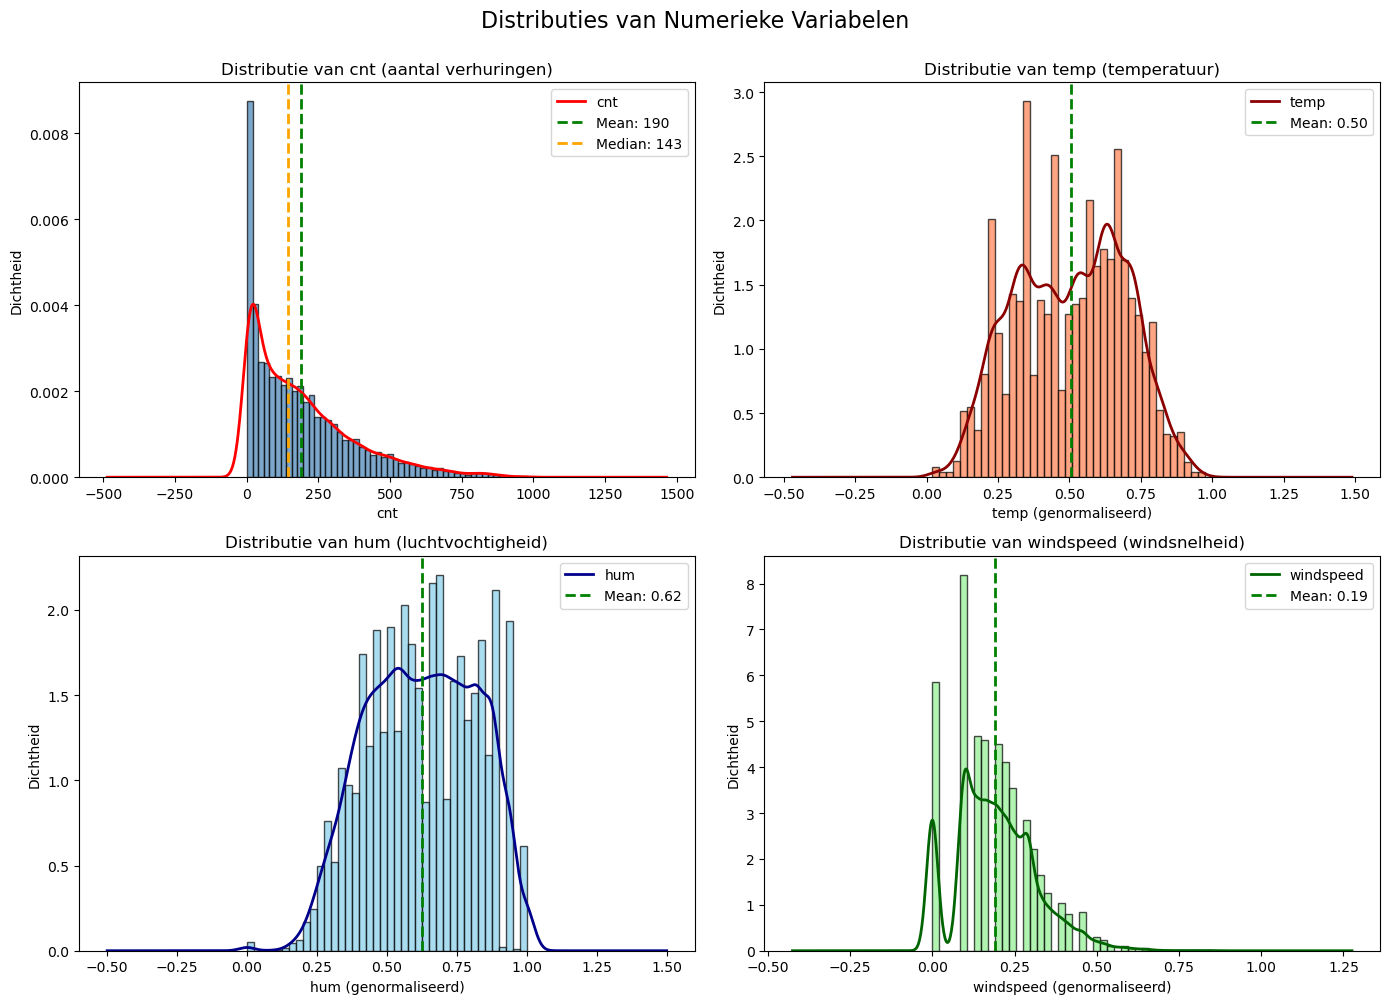

Observaties over distributies:
- cnt: rechtsscheef (skew=1.28), veel lage waarden, enkele pieken
- temp: redelijk normaal verdeeld (skew=-0.07)
- hum: licht linksscheef (skew=-0.11), veel waardes rond 0.6-0.8
- windspeed: rechtsscheef (skew=0.57), veel lage waarden


In [11]:
# Histogrammen met KDE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distributies van Numerieke Variabelen', fontsize=16, y=1.00)

# Cnt distributie weergreven in een kde plot
axes[0, 0].hist(train['cnt'], bins=50, color='steelblue', edgecolor='black', alpha=0.7, density=True)
train['cnt'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2, secondary_y=False)
axes[0, 0].set_title('Distributie van cnt (aantal verhuringen)')
axes[0, 0].set_xlabel('cnt')
axes[0, 0].set_ylabel('Dichtheid')
axes[0, 0].axvline(train['cnt'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {train["cnt"].mean():.0f}')
axes[0, 0].axvline(train['cnt'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {train["cnt"].median():.0f}')
axes[0, 0].legend()

# Temp distributie weergeven in een kde plot
axes[0, 1].hist(train['temp'], bins=40, color='coral', edgecolor='black', alpha=0.7, density=True)
train['temp'].plot(kind='kde', ax=axes[0, 1], color='darkred', linewidth=2)
axes[0, 1].set_title('Distributie van temp (temperatuur)')
axes[0, 1].set_xlabel('temp (genormaliseerd)')
axes[0, 1].set_ylabel('Dichtheid')
axes[0, 1].axvline(train['temp'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {train["temp"].mean():.2f}')
axes[0, 1].legend()

# Hum distributie weergeven in een kde plot
axes[1, 0].hist(train['hum'], bins=40, color='skyblue', edgecolor='black', alpha=0.7, density=True)
train['hum'].plot(kind='kde', ax=axes[1, 0], color='darkblue', linewidth=2)
axes[1, 0].set_title('Distributie van hum (luchtvochtigheid)')
axes[1, 0].set_xlabel('hum (genormaliseerd)')
axes[1, 0].set_ylabel('Dichtheid')
axes[1, 0].axvline(train['hum'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {train["hum"].mean():.2f}')
axes[1, 0].legend()

# Windspeed distributie weergeven in een kde plot
axes[1, 1].hist(train['windspeed'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7, density=True)
train['windspeed'].plot(kind='kde', ax=axes[1, 1], color='darkgreen', linewidth=2)
axes[1, 1].set_title('Distributie van windspeed (windsnelheid)')
axes[1, 1].set_xlabel('windspeed (genormaliseerd)')
axes[1, 1].set_ylabel('Dichtheid')
axes[1, 1].axvline(train['windspeed'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {train["windspeed"].mean():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Observaties uitprinten
print("Observaties over distributies:")
print(f"- cnt: rechtsscheef (skew={train['cnt'].skew():.2f}), veel lage waarden, enkele pieken")
print(f"- temp: redelijk normaal verdeeld (skew={train['temp'].skew():.2f})")
print(f"- hum: licht linksscheef (skew={train['hum'].skew():.2f}), veel waardes rond 0.6-0.8")
print(f"- windspeed: rechtsscheef (skew={train['windspeed'].skew():.2f}), veel lage waarden")

### Observaties over de distributies

- De count variable is right skewed. Veel van de waardes zijn laag met enkele pieken en outliers.
- De temperatuur variable distributie is normally skewed. Alles ziet er hier normaal uit.
- Humidity, of luchtvochtigheid, is heel licht left skewed. Veel van de waardes liggen tussen de 0,6 en 0,8.
- Windspeed is right skewed met een hele lange staart. Er zijn veel lage waardes. Hier is het ook verstandig om de mediaan te nemen.

### 1.3 Categorische variabelen vs cnt
Analyse van het effect van feestdagen en weersomstandigheden op verhuringen

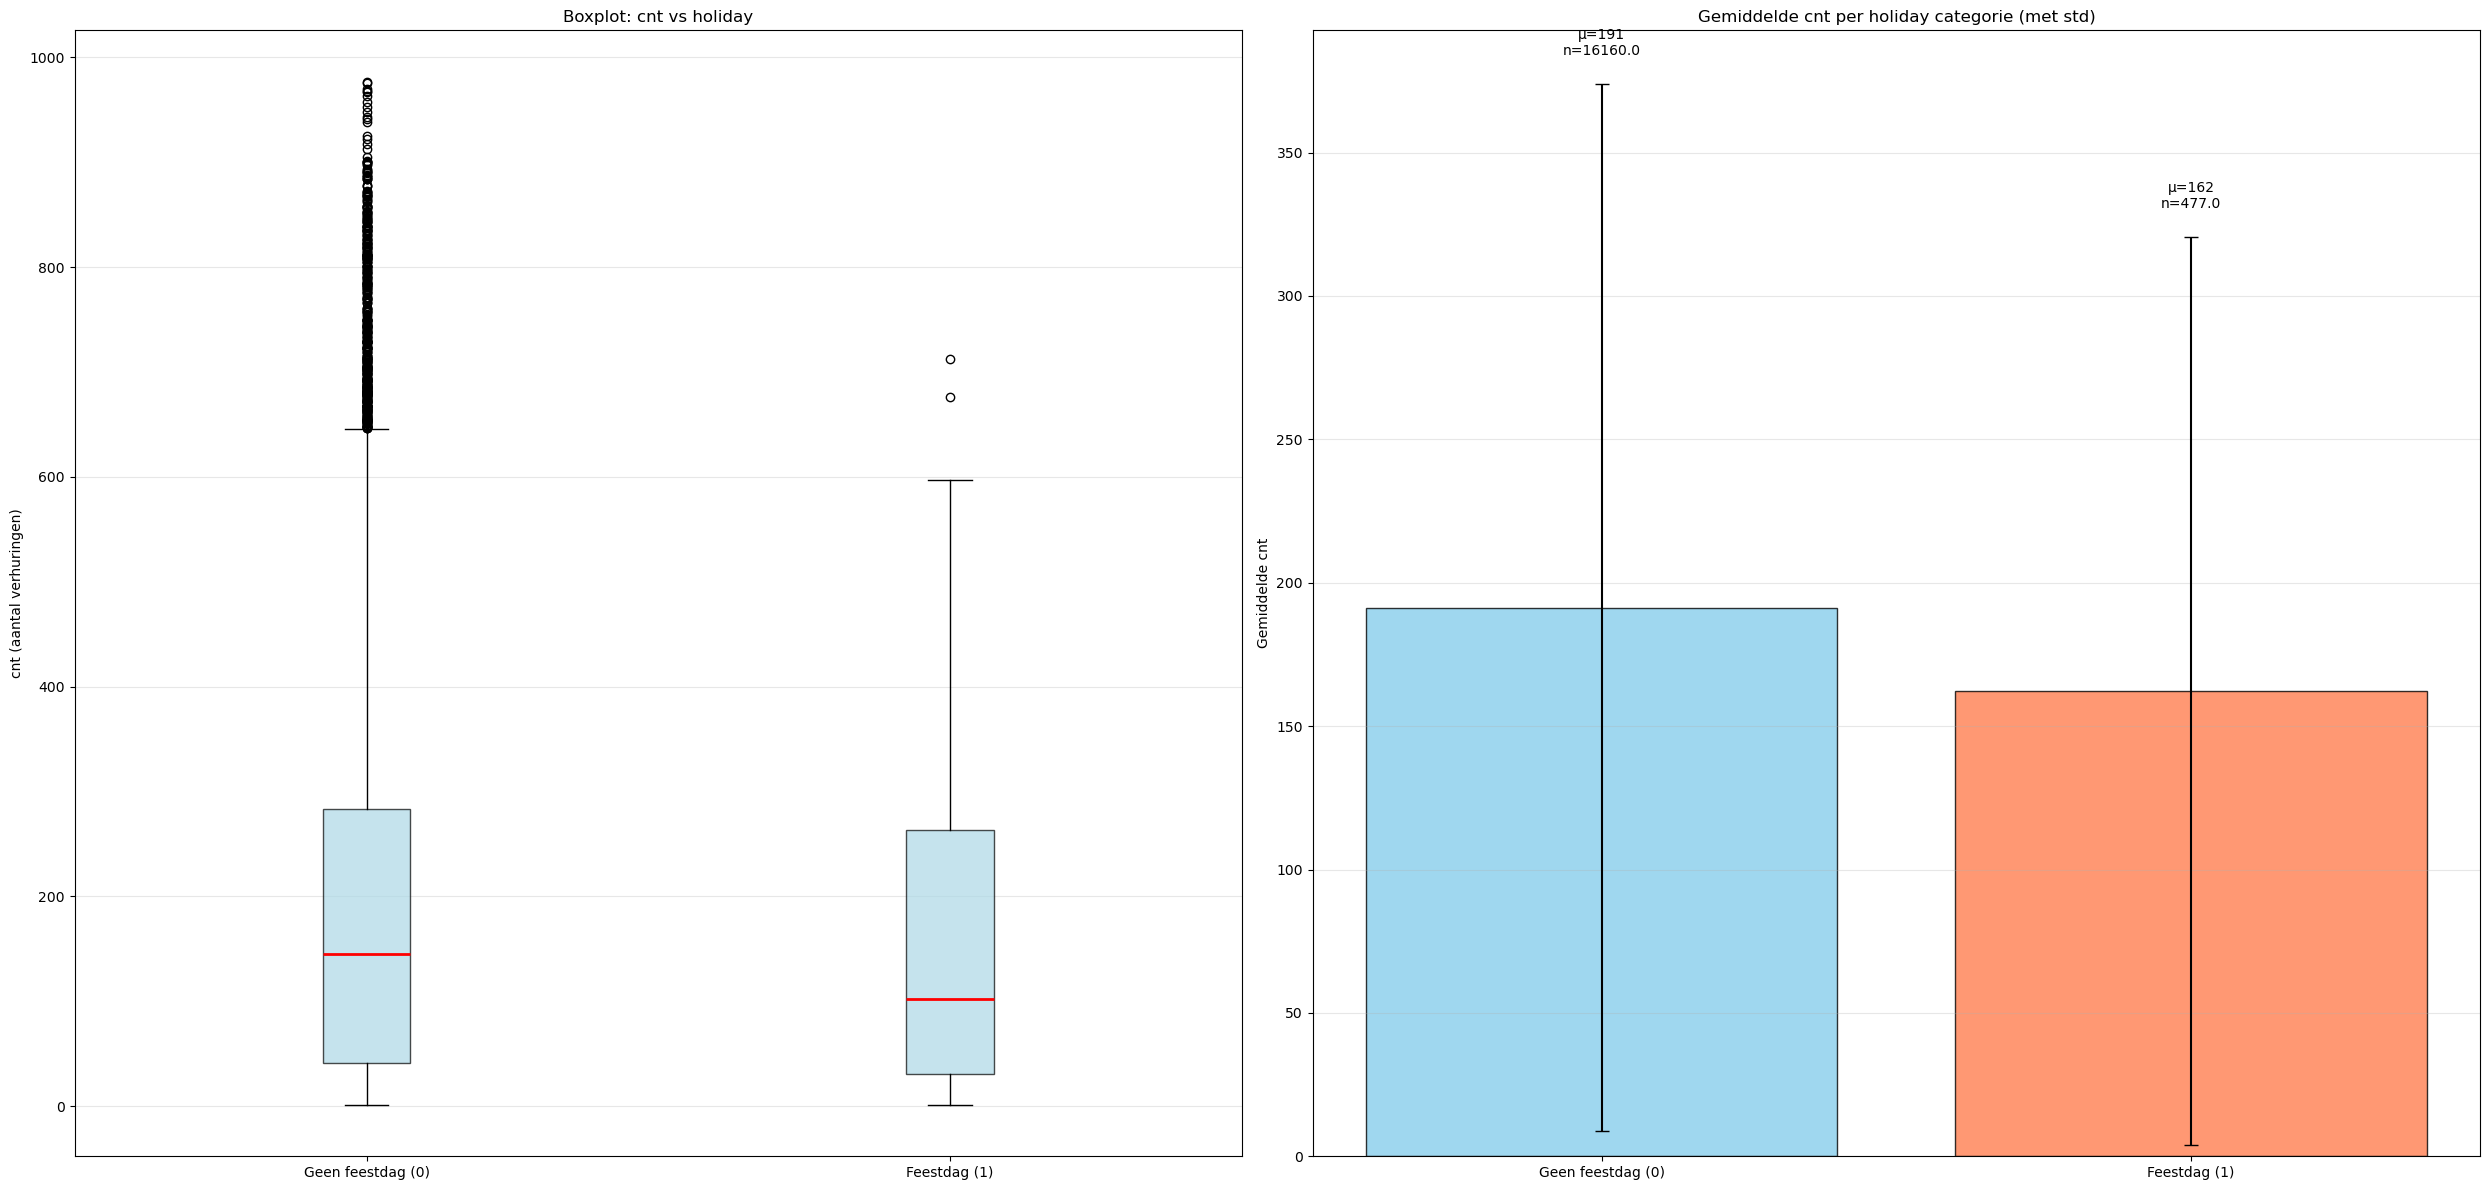

Holiday statistieken:
               mean  median         std  count
holiday                                       
0        191.308416   145.0  182.620310  16160
1        162.310273   102.0  158.231867    477

Conclusie: Feestdagen hebben lagere gemiddelde verhuringen.


In [12]:
# Plot maken van cnt vs holiday (feestdag)
fig, axes = plt.subplots(1, 2, figsize=(25, 12))

# Aanmaken van een boxplot
axes[0].boxplot([train[train['holiday'] == 0]['cnt'], train[train['holiday'] == 1]['cnt']],
                labels=['Geen feestdag (0)', 'Feestdag (1)'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_title('Boxplot: cnt vs holiday')
axes[0].set_ylabel('cnt (aantal verhuringen)')
axes[0].grid(axis='y', alpha=0.3)

# We maken een barplot met het gemiddelde
holiday_stats = train.groupby('holiday')['cnt'].agg(['mean', 'median', 'std', 'count'])
axes[1].bar(['Geen feestdag (0)', 'Feestdag (1)'], holiday_stats['mean'],
           color=['skyblue', 'coral'], edgecolor='black', alpha=0.8)
axes[1].errorbar(['Geen feestdag (0)', 'Feestdag (1)'], holiday_stats['mean'],
                yerr=holiday_stats['std'], fmt='none', color='black', capsize=5)
axes[1].set_title('Gemiddelde cnt per holiday categorie (met std)')
axes[1].set_ylabel('Gemiddelde cnt')
axes[1].grid(axis='y', alpha=0.3)

# Annotaties toevoegen van het gemiddelde en de count
for i, (idx, row) in enumerate(holiday_stats.iterrows()):
    axes[1].text(i, row['mean'] + row['std'] + 10,
                f"μ={row['mean']:.0f}\nn={row['count']}",
                ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Uitprinten van de statistieken die we hebben gevonden van deze analyse
print("Holiday statistieken:")
print(holiday_stats)
print(f"\nConclusie: Feestdagen hebben {'hogere' if holiday_stats.loc[1, 'mean'] > holiday_stats.loc[0, 'mean'] else 'lagere'} gemiddelde verhuringen.")

Op feestdagen worden er minder verhuurt. Dit laat ons denken dat meeste mensen huren om naar hun werk te gaan en naar huis te gaan.  

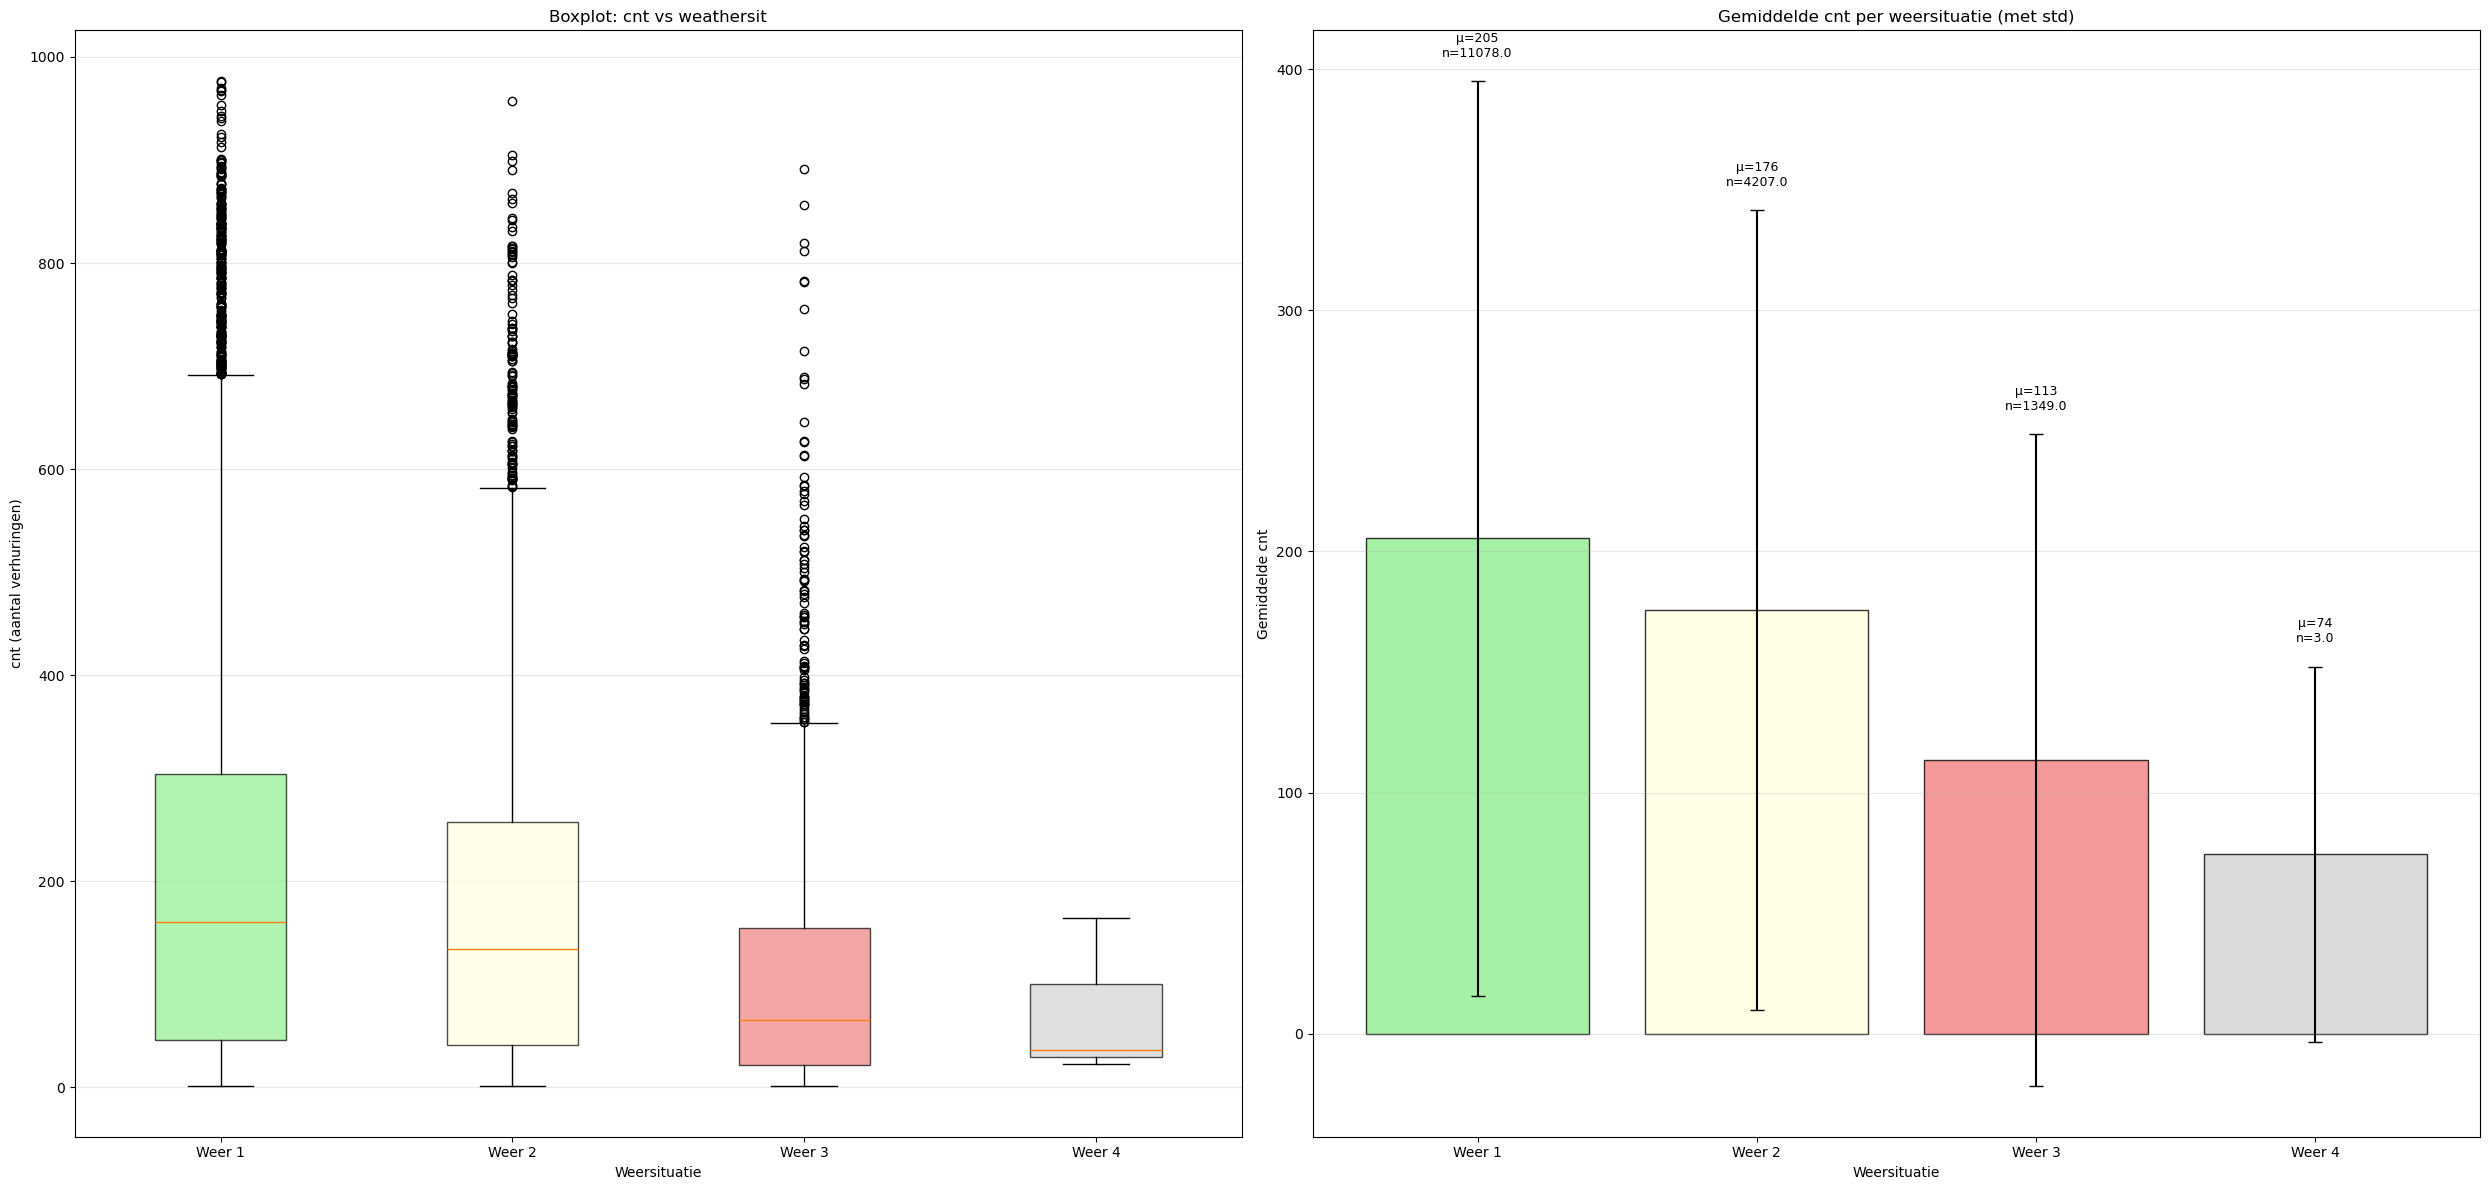

Weathersit statistieken:
                  mean  median         std  count
weathersit                                       
1           205.443492   161.0  189.858234  11078
2           175.846446   134.0  165.924209   4207
3           113.457376    65.0  135.358938   1349
4            74.333333    36.0   77.925178      3

Weersituatie categorieën:
  1 = Helder/licht bewolkt
  2 = Mist/bewolkt
  3 = Lichte sneeuw/regen
  4 = Zware regen/sneeuw (indien aanwezig)

Conclusie: Beter weer is gelijk aan meer verhuringen. Weer 1 heeft hoogste gemiddelde.


In [13]:
# Cnt vs weathersit (weersituatie) plot aanmaken
fig, axes = plt.subplots(1, 2, figsize=(25, 12))

# We beginnen met de boxplot
weather_data = [train[train['weathersit'] == i]['cnt'] for i in sorted(train['weathersit'].unique())]
weather_labels = [f'Weer {i}' for i in sorted(train['weathersit'].unique())]
bp = axes[0].boxplot(weather_data, labels=weather_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightyellow', 'lightcoral', 'lightgray']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('Boxplot: cnt vs weathersit')
axes[0].set_xlabel('Weersituatie')
axes[0].set_ylabel('cnt (aantal verhuringen)')
axes[0].grid(axis='y', alpha=0.3)

# Maken een barplot met het gemiddelde
weather_stats = train.groupby('weathersit')['cnt'].agg(['mean', 'median', 'std', 'count'])
colors_bar = ['lightgreen', 'lightyellow', 'lightcoral', 'lightgray'][:len(weather_stats)]
axes[1].bar(weather_labels, weather_stats['mean'],
           color=colors_bar, edgecolor='black', alpha=0.8)
axes[1].errorbar(weather_labels, weather_stats['mean'],
                yerr=weather_stats['std'], fmt='none', color='black', capsize=5)
axes[1].set_title('Gemiddelde cnt per weersituatie (met std)')
axes[1].set_xlabel('Weersituatie')
axes[1].set_ylabel('Gemiddelde cnt')
axes[1].grid(axis='y', alpha=0.3)

# Annotaties toevoegen aan de plot van het gemiddelde en de count
for i, (idx, row) in enumerate(weather_stats.iterrows()):
    axes[1].text(i, row['mean'] + row['std'] + 10,
                f"μ={row['mean']:.0f}\nn={row['count']}",
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Weathersit statistieken:")
print(weather_stats)
print("\nWeersituatie categorieën:")
print("  1 = Helder/licht bewolkt")
print("  2 = Mist/bewolkt")
print("  3 = Lichte sneeuw/regen")
print("  4 = Zware regen/sneeuw (indien aanwezig)")
print(f"\nConclusie: Beter weer is gelijk aan meer verhuringen. Weer 1 heeft hoogste gemiddelde.")

Uit deze EDA blijkt dat bij beter weer er meer verhuringen plaatsvinden. Dit laat ons weten dat mensen het liefst het object huren wanneer het weer geschikter of mooier is. Bij zonnig weer zijn mensen blijer om te huren, dan bij somber weer.

### 1.4 Uitgebreide tijd-gebaseerde features
Toevoegen van weekend en seizoen features voor betere patronen

In [14]:
# Tijd opsplitsen in nieuwe features
for df in [train, test]:
    df['year'] = df['date_hour'].dt.year
    df['month'] = df['date_hour'].dt.month
    df['day'] = df['date_hour'].dt.day
    df['hour'] = df['date_hour'].dt.hour
    df['dayofweek'] = df['date_hour'].dt.dayofweek
    df['weekofyear'] = df['date_hour'].dt.isocalendar().week.astype(int)

    # Weekend feature (zaterdag=5, zondag=6)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Seizoen feature
    # Winter: 12,1,2 | Lente: 3,4,5 | Zomer: 6,7,8 | Herfst: 9,10,11
    df['season'] = df['month'].apply(lambda x:
        'Winter' if x in [12, 1, 2] else
        'Lente' if x in [3, 4, 5] else
        'Zomer' if x in [6, 7, 8] else
        'Herfst')

print("Nieuwe features toegevoegd:")
print(train[['date_hour', 'month', 'dayofweek', 'is_weekend', 'season']].head(10))

Nieuwe features toegevoegd:
            date_hour  month  dayofweek  is_weekend  season
0 2011-01-01 00:00:00      1          5           1  Winter
1 2011-01-01 01:00:00      1          5           1  Winter
2 2011-01-01 02:00:00      1          5           1  Winter
3 2011-01-01 03:00:00      1          5           1  Winter
4 2011-01-01 04:00:00      1          5           1  Winter
5 2011-01-01 05:00:00      1          5           1  Winter
6 2011-01-01 06:00:00      1          5           1  Winter
7 2011-01-01 07:00:00      1          5           1  Winter
8 2011-01-01 08:00:00      1          5           1  Winter
9 2011-01-01 09:00:00      1          5           1  Winter


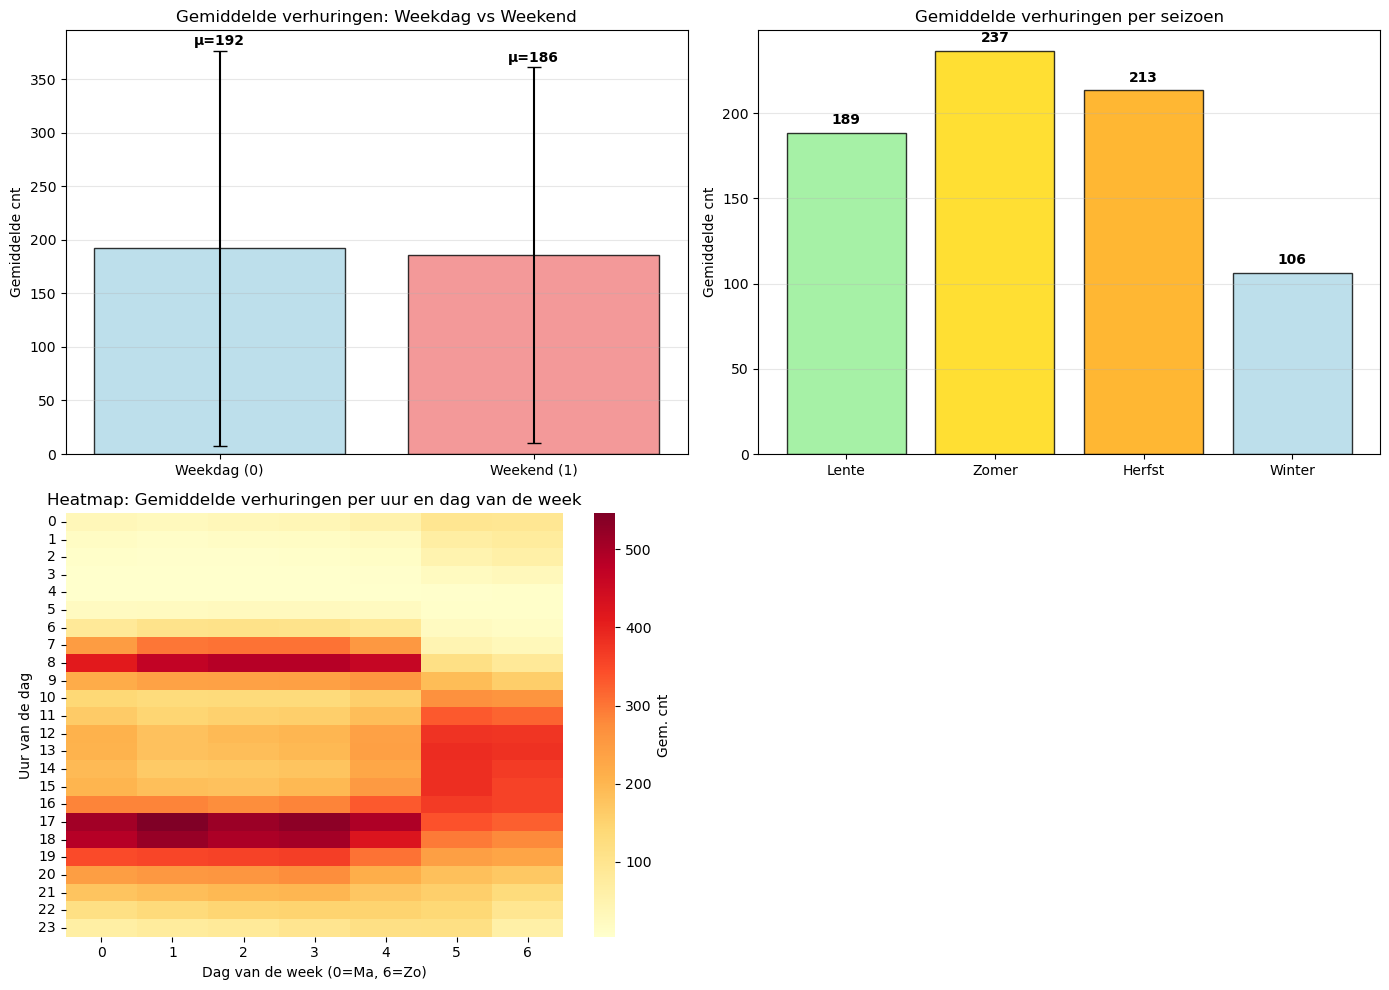


Bevindingen nieuwe tijd-features:
- Weekend gemiddelde: 186 vs Weekdag: 192
- Beste seizoen: Zomer (μ=237)
- Slechtste seizoen: Winter (μ=106)
- Heatmap toont duidelijke piekuren tijdens ochtend- en avondspits op werkdagen


In [15]:
# Visualisaties voor de nieuw aangemaakte tijd features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. vergelijken cnt vs is_weekend
weekend_stats = train.groupby('is_weekend')['cnt'].agg(['mean', 'std', 'count'])
axes[0, 0].bar(['Weekdag (0)', 'Weekend (1)'], weekend_stats['mean'],
              color=['lightblue', 'lightcoral'], edgecolor='black', alpha=0.8)
axes[0, 0].errorbar(['Weekdag (0)', 'Weekend (1)'], weekend_stats['mean'],
                   yerr=weekend_stats['std'], fmt='none', color='black', capsize=5)
axes[0, 0].set_title('Gemiddelde verhuringen: Weekdag vs Weekend')
axes[0, 0].set_ylabel('Gemiddelde cnt')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(weekend_stats.iterrows()):
    axes[0, 0].text(i, row['mean'] + row['std'] + 5,
                   f"μ={row['mean']:.0f}", ha='center', fontsize=10, fontweight='bold')

# 2. Vergelijken cnt vs season
season_order = ['Lente', 'Zomer', 'Herfst', 'Winter']
season_stats = train.groupby('season')['cnt'].mean().reindex(season_order)
colors_season = ['lightgreen', 'gold', 'orange', 'lightblue']
axes[0, 1].bar(season_order, season_stats, color=colors_season, edgecolor='black', alpha=0.8)
axes[0, 1].set_title('Gemiddelde verhuringen per seizoen')
axes[0, 1].set_ylabel('Gemiddelde cnt')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, val in enumerate(season_stats):
    axes[0, 1].text(i, val + 5, f"{val:.0f}", ha='center', fontsize=10, fontweight='bold')

# 3. Heatmap: uur vs dag van de week
pivot_hour_day = train.pivot_table(values='cnt', index='hour', columns='dayofweek', aggfunc='mean')
sns.heatmap(pivot_hour_day, cmap='YlOrRd', annot=False, fmt='.0f', ax=axes[1, 0], cbar_kws={'label': 'Gem. cnt'})
axes[1, 0].set_title('Heatmap: Gemiddelde verhuringen per uur en dag van de week')
axes[1, 0].set_xlabel('Dag van de week (0=Ma, 6=Zo)')
axes[1, 0].set_ylabel('Uur van de dag')


axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

print("\nBevindingen nieuwe tijd-features:")
print(f"- Weekend gemiddelde: {weekend_stats.loc[1, 'mean']:.0f} vs Weekdag: {weekend_stats.loc[0, 'mean']:.0f}")
print(f"- Beste seizoen: {season_stats.idxmax()} (μ={season_stats.max():.0f})")
print(f"- Slechtste seizoen: {season_stats.idxmin()} (μ={season_stats.min():.0f})")
print("- Heatmap toont duidelijke piekuren tijdens ochtend- en avondspits op werkdagen")

Het gemiddelde van het verhuurde product in het weekend is 186, terwijl dat van de weekdag 192 is. Dit laat zien dat er in het weekend nogsteeds veel van het product verhuurt worden, maar doordeweeks meer.

<br>Het beste seizoen is in de zomer. Dit betekent dat het product het beste verhuurt wordt tijdens warm weer. Het gemiddelde hier is 237.

<br>Het slechtste seizoen is de winter waar er een stuk minder producten verhuurt worden. Hier is het gemiddelde ook minder dan de helft van zomer, op slechts 106.

<br>De heatmap laat duidelijk zien dat er een ochtend en avond spits is. Dit komt overeen met de gedachte dat mensen dit product doordeweeks huren en om naar en van werk te reizen.

### 1.5 Weeranalyse
#### Diepere exploratie van hoe weersomstandigheden de verhuringen beïnvloeden

C:\Users\caitl\AppData\Local\Temp\ipykernel_10524\371187148.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train.groupby([temp_bins, 'weathersit'])['cnt'].median().unstack()
C:\Users\caitl\AppData\Local\Temp\ipykernel_10524\371187148.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  temp_hum_effect = train.pivot_table(values='cnt', index='temp_bin', columns='hum_bin', aggfunc='mean')


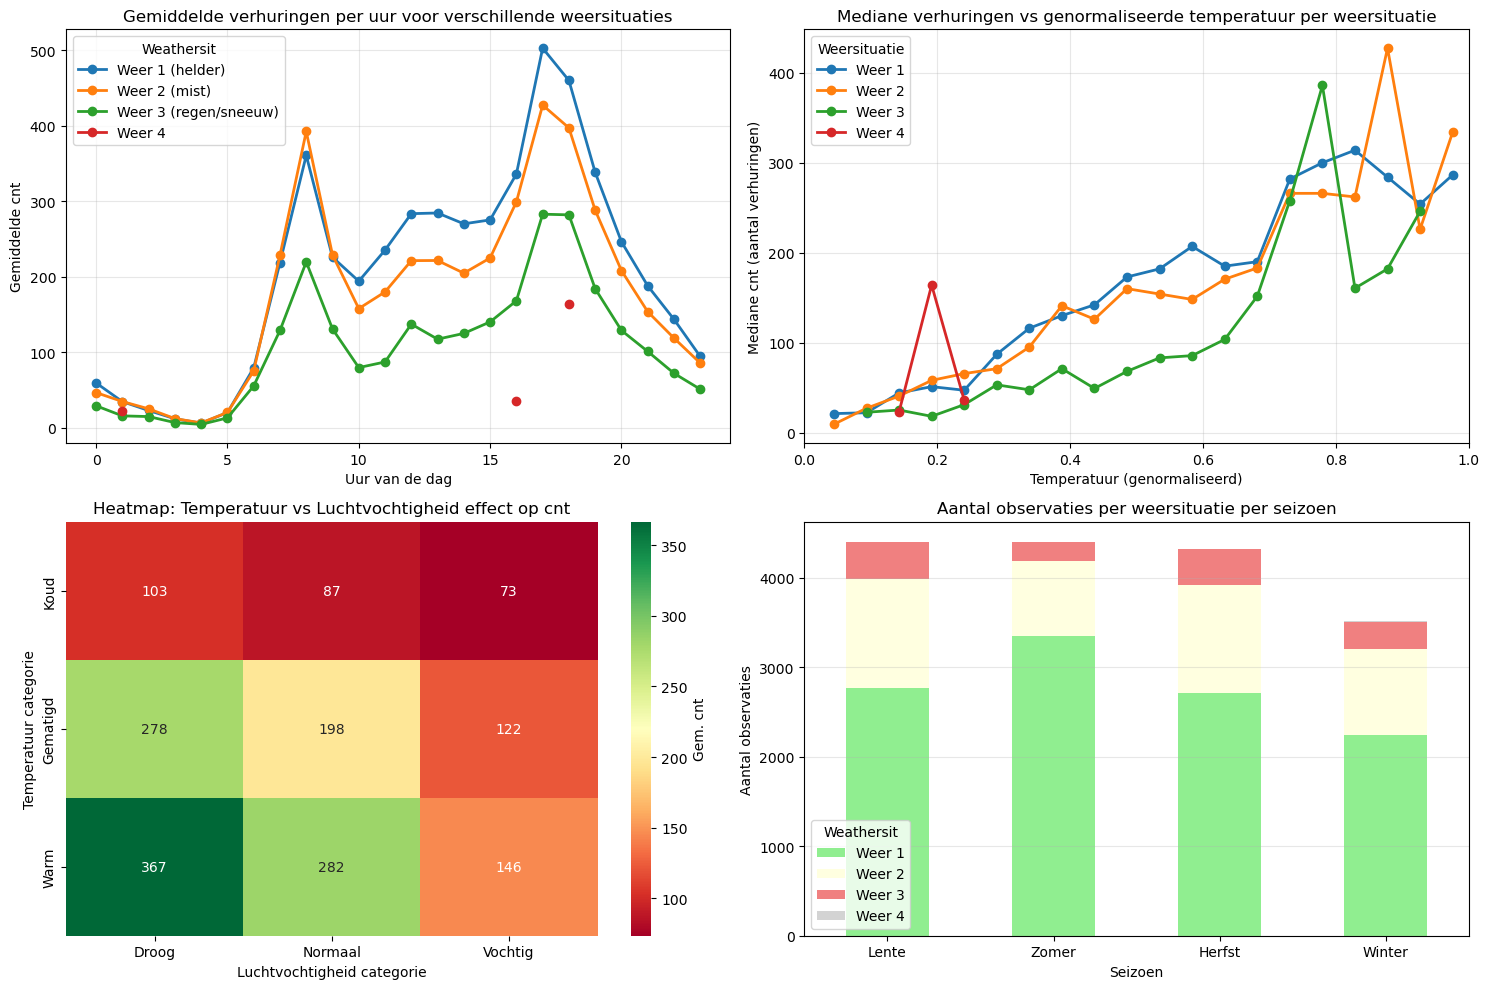

Weereffect samenvatting:
                  mean  median         std  min  max  count
weathersit                                                 
1           205.443492   161.0  189.858234    1  977  11078
2           175.846446   134.0  165.924209    1  957   4207
3           113.457376    65.0  135.358938    1  891   1349
4            74.333333    36.0   77.925178   23  164      3

Temperatuur effect samenvatting:
                mean  count
temp_bin                   
Koud       89.036598   3716
Gematigd  188.085898   9197
Warm      297.604726   3724

Luchtvochtigheid effect samenvatting:
               mean  count
hum_bin                   
Droog    260.745389   4988
Normaal  193.631422   6715
Vochtig  115.535423   4912


C:\Users\caitl\AppData\Local\Temp\ipykernel_10524\371187148.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train.groupby('temp_bin')['cnt'].agg(['mean', 'count']))
C:\Users\caitl\AppData\Local\Temp\ipykernel_10524\371187148.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train.groupby('hum_bin')['cnt'].agg(['mean', 'count']))


In [16]:
# Uitgebreide weeranalyse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Weersituatie per uur van de dag
weather_hour = train.pivot_table(values='cnt', index='hour', columns='weathersit', aggfunc='mean')
weather_hour.plot(ax=axes[0, 0], marker='o', linewidth=2)
axes[0, 0].set_title('Gemiddelde verhuringen per uur voor verschillende weersituaties')
axes[0, 0].set_xlabel('Uur van de dag')
axes[0, 0].set_ylabel('Gemiddelde cnt')
axes[0, 0].legend(title='Weathersit', labels=['Weer 1 (helder)', 'Weer 2 (mist)', 'Weer 3 (regen/sneeuw)', 'Weer 4'])
axes[0, 0].grid(alpha=0.3)

# 2. Temperatuur impact per weersituatie (lijnplot, geaggregeerd op temp bins)
temp_bins = pd.cut(train['temp'], bins=20)
# Gebruik median voor robuuste samenvatting bij skewed target; vervang .median() door .mean() als je het gemiddelde wilt
grouped = train.groupby([temp_bins, 'weathersit'])['cnt'].median().unstack()

colors = sns.color_palette('tab10', n_colors=grouped.shape[1])

# X-waarden: midpoints van de bins
x = [interval.mid for interval in grouped.index]

axes[0, 1].cla()
for col, color in zip(grouped.columns, colors):
    axes[0, 1].plot(x, grouped[col].values, marker='o', linewidth=2, label=f'Weer {int(col)}', color=color)

axes[0, 1].set_title('Mediane verhuringen vs genormaliseerde temperatuur per weersituatie')
axes[0, 1].set_xlabel('Temperatuur (genormaliseerd)')
axes[0, 1].set_ylabel('Mediane cnt (aantal verhuringen)')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend(title='Weersituatie')

# 3. Gecombineerde effect: temp en humidity bins
train['temp_bin'] = pd.cut(train['temp'], bins=[0, 0.33, 0.66, 1.0], labels=['Koud', 'Gematigd', 'Warm'])
train['hum_bin'] = pd.cut(train['hum'], bins=[0, 0.5, 0.75, 1.0], labels=['Droog', 'Normaal', 'Vochtig'])
temp_hum_effect = train.pivot_table(values='cnt', index='temp_bin', columns='hum_bin', aggfunc='mean')
sns.heatmap(temp_hum_effect, annot=True, fmt='.0f', cmap='RdYlGn', ax=axes[1, 0], cbar_kws={'label': 'Gem. cnt'})
axes[1, 0].set_title('Heatmap: Temperatuur vs Luchtvochtigheid effect op cnt')
axes[1, 0].set_ylabel('Temperatuur categorie')
axes[1, 0].set_xlabel('Luchtvochtigheid categorie')

# 4. Weersituatie verdeling per seizoen
weather_season = train.pivot_table(values='cnt', index='season', columns='weathersit', aggfunc='count')
weather_season = weather_season.reindex(['Lente', 'Zomer', 'Herfst', 'Winter'])
weather_season.plot(kind='bar', stacked=True, ax=axes[1, 1],
                   color=['lightgreen', 'lightyellow', 'lightcoral', 'lightgray'])
axes[1, 1].set_title('Aantal observaties per weersituatie per seizoen')
axes[1, 1].set_xlabel('Seizoen')
axes[1, 1].set_ylabel('Aantal observaties')
axes[1, 1].legend(title='Weathersit', labels=['Weer 1', 'Weer 2', 'Weer 3', 'Weer 4'])
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistieken weergeven
print("Weereffect samenvatting:")
weather_summary = train.groupby('weathersit')['cnt'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(weather_summary)
print("\nTemperatuur effect samenvatting:")
print(train.groupby('temp_bin')['cnt'].agg(['mean', 'count']))
print("\nLuchtvochtigheid effect samenvatting:")
print(train.groupby('hum_bin')['cnt'].agg(['mean', 'count']))

### 1.6 EDA: samenvatting en conclusie


#### 1. Data kwaliteit en geschiktheid voor ML
- Dataset grootte: 16637 rijen en 18 kolommen
- Geen missende waarden: alle features zijn compleet
- Geen negatieve of onrealistische waarden gevonden
- Alle genormaliseerde features (temp, hum, windspeed) binnen bereik [0,1]
- Geen dubbele timestamps: elke punt is uniek
- Target variabele 'cnt' heeft logische waarden (0-977)

De data waarmij wij te werk gaan is geschikt voor ML zonder extra cleaning


#### 2. Distributie kenmerken
Cnt (target) is right skewed verdeeld en heeft veel hoge waardes als outliers
  - Veel lage waarden met enkele hoge pieken tijdens spitsuren
  - Mediaan: 143, Gemiddelde: 190
De temperatuur is ongeveer normaal verdeeld, hier is niks mis mee.
Humidity(luchtvochtigeid) is licht left skewed, met veel datapunten rond 0.6-0.8
windspeed: Right skewed, veel lage waarden die de gemiddelde lager trekken


#### 3. Temporele patronen (rush hours & tijdeffecten)
• Piekuren voor verhuringen:
  - 17:00 uur → gemiddeld 465 verhuringen
  - 18:00 uur → gemiddeld 430 verhuringen
  - 8:00 uur → gemiddeld 359 verhuringen
Dit weergeeft een duidelijke ochtendspits (7-9 uur) en avondspits (17-19 uur) wat overeen komt met werktijden
Laagste verhuringen vinden plaats in de vroege ochtend (3-5 uur), dit is wanneer meeste mensen aan het slapen zijn
Het patroon wijst sterk op dat het product wordt gehuurd voor woon-werk verkeer


#### 4. Weekdag en weekend patronen
• Weekdag gemiddelde: 192 verhuringen
• Weekend gemiddelde: 186 verhuringen
Weekdagen zijn 3.4% hoger dan de weekenden. Het is mogelijk dat er in het weekend recreatief gebruik wordt gemaakt van de verhuurde product, en doordeweeks een woon-werkverkeer plaats vindt.

#### 5. Weer- en seizoenseffecten
• Weersituatie impact op verhuringen:
  - Weer 1: gemiddeld 205 verhuringen
  - Weer 2: gemiddeld 176 verhuringen
  - Weer 3: gemiddeld 113 verhuringen
  - Weer 4: gemiddeld 74 verhuringen
  (1=helder, 2=mist/bewolkt, 3=lichte regen/sneeuw/ 4 = zware regen/sneeuw)
Helder weer heeft 205 verhuringen (hoogste), terwijl slecht weer 74 verhuringen heeft wat het laagst is. Er is dus bij goed weer rond 176% meer verhuringen dan bij slecht weer.

• Seizoenspatronen:
  - Lente: gemiddeld 189 verhuringen
  - Zomer: gemiddeld 237 verhuringen
  - Herfst: gemiddeld 213 verhuringen
  - Winter: gemiddeld 106 verhuringen
Het beste seizoen is de Zomer met een gemiddelde van 237 verhuringen, de slechtste is winter... met een gemiddelde van 106 verhuringen.

#### 6. Temperatuur & luchtvochtigheid effecten
Temperatuur correleert positief met cnt. Hogere temp staat gelijk aan meer verhuringen. Daarintegen correleert luchtvochtigheid negatief hier mee. Dit betekent dat bij een hogere vochtigheid er minder verhuurt wordt.
Wind snelheid correleert niet veel met cnt.
Volgens de gegevens dus zijn warme en droge dagen met weinig wind de ideale tijd voor verhuringen, koude dagen met hoge vochtigheid en veel wind resulteren in weinig verhuringen.


#### 7. Feestdagen effect
Normale dagen hebeben gemiddeld verhuringen van 191, terwijl feestdagen gemiddeld 162 verhuringen hebben. Dit is een drop van 15%. Dit kan betekenen dat bij feestdagen er meer recreatief gebruik gemaakt wordt van het product dan normale dagen.


#### 8. Belangrijkste features voor ML modellen
Top predictors (gebaseerd op correlatie en EDA):
  1. hour (uur van de dag) - sterke temporele patronen
  2. temp (temperatuur) - positieve correlatie
  3. season (seizoen) - duidelijke seizoensvariatie
  4. weathersit (weersituatie) - grote impact op gebruik
  5. is_weekend (weekend indicator) - gebruiksverschillen
  6. hum (luchtvochtigheid) - negatieve correlatie
  7. month (maand) - seizoenstrend
  8. dayofweek (dag vd week) - weekpatronen
  9. holiday (feestdag) - speciaal gebruik
  10. windspeed (windsnelheid) - klein effect


#### 9. EDA conclusie


De dataset is goed geschikt voor machine learning omdat:

- Data is volledig compleet. Er zijn geen missende waarden of fouten
- Duidelijke patronen zijn aanwezig: seizoens, weer etc.
- Features hebben logische relaties met de target variabele
- Er is voldoende data beschikbaar voor training (16637 observaties)
- Het heeft geen data cleaning nodig en is dus direct bruikbaar
- Features zijn al genormaliseerd (temp, hum, windspeed)
- Sterke predictive signals in tijd-gebaseerde features


## 2. Opdracht 2  Timeseries feature engineering


In [17]:
# Zorgen dat date_hour zeker datetime is
train['date_hour'] = pd.to_datetime(train['date_hour'])
test['date_hour'] = pd.to_datetime(test['date_hour'])

# Basis-tijdfeatures aanmaken
for df in [train, test]:
    if 'hour' not in df.columns:
        df['hour'] = df['date_hour'].dt.hour
    if 'dayofweek' not in df.columns:
        df['dayofweek'] = df['date_hour'].dt.dayofweek
    if 'month' not in df.columns:
        df['month'] = df['date_hour'].dt.month

# Globale tijdsindex (in uren sinds start) zodat train en test dezelfde schaal hebben
global_start = min(train['date_hour'].min(), test['date_hour'].min())

for df in [train, test]:
    df['t_hours'] = (df['date_hour'] - global_start).dt.total_seconds() / 3600.0

def add_fourier_features(df, period, order, prefix):
    """
    df: DataFrame met kolom 't_hours'
    period: periode in uren (bijv. 24 voor dagelijks, 168 voor wekelijks)
    order: aantal sin/cos-paar componenten
    prefix: naam-prefix, bijv. 'day', 'week' of 'year'
    """
    for k in range(1, order + 1):
        df[f'{prefix}_sin_{k}'] = np.sin(2 * np.pi * k * df['t_hours'] / period)
        df[f'{prefix}_cos_{k}'] = np.cos(2 * np.pi * k * df['t_hours'] / period)

# Dagelijkse (24 uur), wekelijkse (7*24) en jaarlijkse (~365*24) seizoenen
add_fourier_features(train, period=24, order=3, prefix='day')
add_fourier_features(test,  period=24, order=3, prefix='day')

add_fourier_features(train, period=24*7, order=2, prefix='week')
add_fourier_features(test,  period=24*7, order=2, prefix='week')

add_fourier_features(train, period=24*365, order=1, prefix='year')
add_fourier_features(test,  period=24*365, order=1, prefix='year')

print("Fourier features toegevoegd:")
fourier_cols = [c for c in train.columns if c.startswith(('day_', 'week_', 'year_'))]
print(fourier_cols[:10], "... (totaal:", len(fourier_cols), ")")



Fourier features toegevoegd:
['day_sin_1', 'day_cos_1', 'day_sin_2', 'day_cos_2', 'day_sin_3', 'day_cos_3', 'week_sin_1', 'week_cos_1', 'week_sin_2', 'week_cos_2'] ... (totaal: 12 )


### Toelichting
In deze cel wordt de datum kolom nog een keer goed omgezet naar een echt datum tijdformaat. Daarna wordt er een nieuwe kolom gemaakt die aangeeft hoeveel uur er is verstreken sinds het begin van de dataset. Deze kolom noemen we t_hours. Dit is handig omdat we zo wiskundige tijdsfuncties kunnen gebruiken.
Daarna voegen we speciale tijdsfeatures toe, namelijk Fourier features. Deze sin/cos waarden helpen het model om terugkerende patronen te leren, zoals:
- elke dag → mensen huren meer op bepaalde uren
- elke week → in het weekend is het patroon anders
- elk jaar → seizoenen hebben effect

### 2.1 Fourier analyse: seizoenspatronen zichtbaar maken

C:\Users\caitl\AppData\Local\Temp\ipykernel_10524\3527241777.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_hourly = train.set_index('date_hour')['cnt'].asfreq('H')


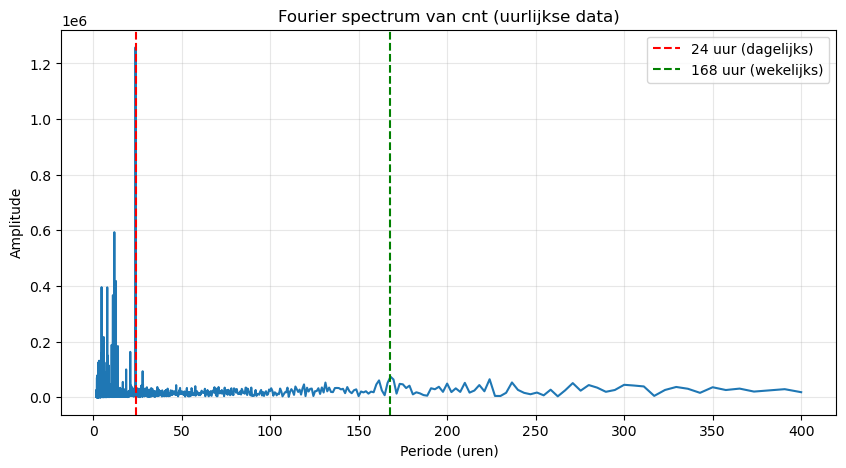

Belangrijkste gevonden periodes (uren):
  Periode ≈ 24.0 uur, amplitude = 1258375
  Periode ≈ 12.0 uur, amplitude = 593332
  Periode ≈ 8400.0 uur, amplitude = 578869
  Periode ≈ 16800.0 uur, amplitude = 496698
  Periode ≈ 12.9 uur, amplitude = 417745


In [18]:
# Uurlijkse tijdreeks met vaste frequentie en interpolatie van eventuele gaten
ts_hourly = train.set_index('date_hour')['cnt'].asfreq('H')
ts_hourly_interp = ts_hourly.interpolate('time')

# FFT value
fft_vals = np.fft.rfft(ts_hourly_interp - ts_hourly_interp.mean())
freqs = np.fft.rfftfreq(len(ts_hourly_interp), d=1.0)  # d=1 uur

# Omzetten naar periodes (in uren), freq=0 overslaan
periods = 1 / freqs[1:]
amplitudes = np.abs(fft_vals)[1:]

# Plot maken: amplitude vs periode
mask = periods <= 400  # focus op dagelijkse/wekelijkse schaal
plt.figure(figsize=(10, 5))
plt.plot(periods[mask], amplitudes[mask])
plt.axvline(24, color='red', linestyle='--', label='24 uur (dagelijks)')
plt.axvline(24*7, color='green', linestyle='--', label='168 uur (wekelijks)')
plt.xlabel("Periode (uren)")
plt.ylabel("Amplitude")
plt.title("Fourier spectrum van cnt (uurlijkse data)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Periodes met grootste amplitudes opzoeken (top 5)
top_idx = np.argsort(amplitudes)[-5:][::-1]
top_periods = periods[top_idx]
top_amps = amplitudes[top_idx]

print("Belangrijkste gevonden periodes (uren):")
for p, a in zip(top_periods, top_amps):
    print(f"  Periode ≈ {p:.1f} uur, amplitude = {a:.0f}")


#### Toelichting

In deze cel wordt een Fourier analyse uitgevoerd om te ontdekken welke tijdspatronen het sterkst aanwezig zijn in de dataset. Door de uurlijkse verhuurdata om te zetten naar het frequentiedomein zien we welke periodes zich herhalen. De grafiek laat dit duidelijk zien dat er een grote piek is bij 24 uur, wat betekent dat er een sterke dagelijkse cyclus is (ochtend- en avondspits). Daarnaast is er een tweede piek rond 168 uur, wat staat voor een wekelijkse cyclus (verschillende patronen doordeweeks en in het weekend). Deze resultaten bevestigen dat het zinvol is om Fourier-features toe te voegen, omdat het model daarmee deze vaste ritmes beter kan leren.

### 2.2  Trends, cycli en autocorrelatie

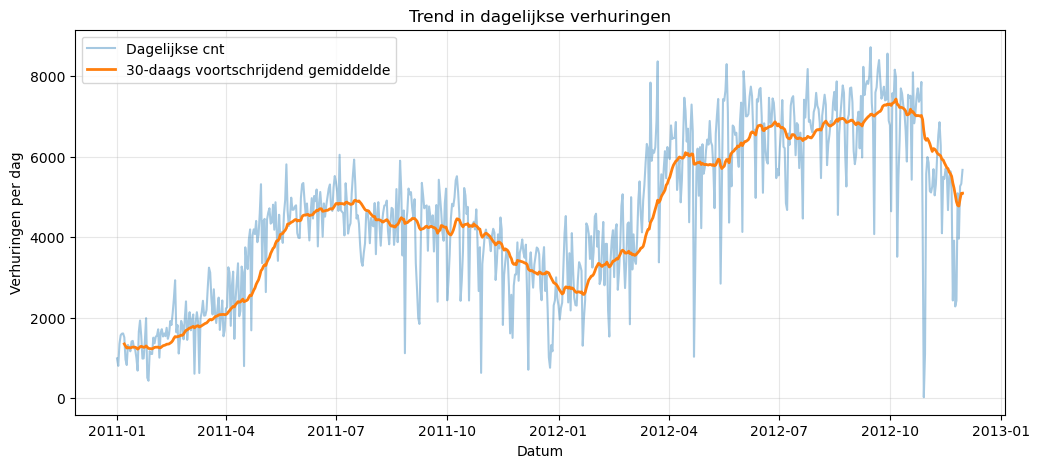

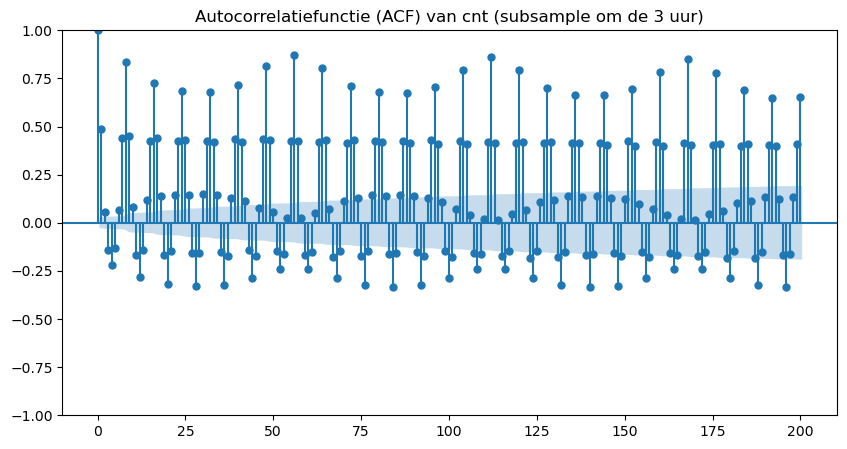

In [19]:
# Trend en autocorrelatie (cycli)
# Dagelijkse aggregatie om het grote plaatje te zien
daily_cnt = train.set_index('date_hour')['cnt'].resample('D').sum()

# Moving average als trendcomponent
trend_30d = daily_cnt.rolling(window=30, min_periods=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(daily_cnt.index, daily_cnt.values, alpha=0.4, label='Dagelijkse cnt')
plt.plot(trend_30d.index, trend_30d.values, linewidth=2, label='30-daags voortschrijdend gemiddelde')
plt.title("Trend in dagelijkse verhuringen")
plt.xlabel("Datum")
plt.ylabel("Verhuringen per dag")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Autocorrelatie van de uurlijkse data (subsample op elke 3e uur om het wat sneller te maken)
ts_sub = ts_hourly_interp.iloc[::3]

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ts_sub, lags=200, ax=ax)
ax.set_title("Autocorrelatiefunctie (ACF) van cnt (subsample om de 3 uur)")
plt.show()


### Toelichting
In deze cel bekijken we hoe het aantal verhuringen verandert over de tijd. De bovenste grafiek toont de dagelijkse verhuringen samen met een 30 daags voortschrijdend gemiddelde. De oranje lijn laat duidelijk zien dat er over de maanden een stijgende trend is, met pieken in de zomer en dalen in de winter. Dit bevestigt het seizoenseffect dat we eerder zagen.

De onderste grafiek is de autocorrelatie (ACF). Deze laat zien hoe sterk de verhuur van nu lijkt op die van eerdere momenten. De duidelijke pieken bij o.a. 24 uur en 168 uur laten zien dat het patroon zich elke dag en elke week herhaalt. Dat betekent dat er sterke dagelijkse en wekelijkse cycli in de data zitten. Hierdoor weten we dat lag features en Fourier features heel belangrijk zijn om goede voorspellingen te maken.

### 2.3  Extra tijdsgebaseerde features: lags & rolling statistics

In [20]:
# Lag en rolling features
# Eerst op tijd sorteren om lags goed te kunnen berekenen
train = train.sort_values('date_hour')

# Lags: vorige uur, vorige dag (24 uur), vorige week (168 uur)
lag_steps = [1, 24, 168]
for lag in lag_steps:
    train[f'cnt_lag_{lag}'] = train['cnt'].shift(lag)

# Rolling mean nemen als smooth trend/level
train['cnt_roll_24']  = train['cnt'].rolling(window=24,  min_periods=1).mean()
train['cnt_roll_168'] = train['cnt'].rolling(window=168, min_periods=1).mean()

print("Nieuwe lag & rolling features toegevoegd:")
print([c for c in train.columns if c.startswith('cnt_lag_') or c.startswith('cnt_roll_')])

# Kleine check: sample waarin alle lags gedefinieerd zijn
print("\nrijen met lags:")
display(train[['date_hour', 'cnt'] + [f'cnt_lag_{l}' for l in lag_steps] + ['cnt_roll_24', 'cnt_roll_168']].head(200).tail(5))


Nieuwe lag & rolling features toegevoegd:
['cnt_lag_1', 'cnt_lag_24', 'cnt_lag_168', 'cnt_roll_24', 'cnt_roll_168']

rijen met lags:


,date_hour,cnt,cnt_lag_1,cnt_lag_24,cnt_lag_168,cnt_roll_24,cnt_roll_168
195,2011-01-09 10:00:00,49,19.0,61.0,6.0,38.375000,56.410714
196,2011-01-09 11:00:00,49,49.0,62.0,3.0,37.833333,56.684524
197,2011-01-09 12:00:00,83,49.0,98.0,2.0,37.208333,57.166667
198,2011-01-09 13:00:00,75,83.0,102.0,1.0,36.083333,57.607143
199,2011-01-09 14:00:00,72,75.0,95.0,8.0,35.125000,57.988095


### Toelichting
In deze cel worden nieuwe tijdseries features toegevoegd die het model meer informatie geven over het recente verleden. De lag kolommen (cnt_lag_1, cnt_lag_24, cnt_lag_168) laten zien hoeveel verhuringen er 1 uur geleden, 24 uur geleden en 168 uur geleden waren. Hierdoor krijgt het model een soort geheugen van de vorige uren, vorige dag en vorige week.

Daarnaast worden rollende gemiddelden (cnt_roll_24 en cnt_roll_168) toegevoegd, die het gemiddelde aantal verhuringen van de afgelopen 24 uur en de afgelopen week weergeven. Dit geeft het model inzicht in de lokale trend en het algemene niveau van de verhuur in recente periodes. Deze features zijn belangrijk omdat het aantal verhuringen van nu vaak sterk lijkt op dat van kort geleden, en modellen hierdoor veel beter tijdspatronen kunnen voorspellen.

### 2.4  Andere tijdsgebaseerde features (cyclische encodingen)

In [21]:
# Cyclische encodingen van uur, dag van de week en maand
for df in [train, test]:
    # Uur van de dag: 0-23
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Dag van de week: 0-6
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Maand: 1-12 -> 0-11
    df['month0'] = df['month'] - 1
    df['month_sin'] = np.sin(2 * np.pi * df['month0'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month0'] / 12)

print("Cyclische tijdfeatures toegevoegd: hour_sin/cos, dow_sin/cos, month_sin/cos")


Cyclische tijdfeatures toegevoegd: hour_sin/cos, dow_sin/cos, month_sin/cos


### Toelichting
in deze cel worden tijdsvariabelen zoals het uur van de dag, de dag van de week en de maand omgezet naar zogeheten cyclische encodingen (sinus en cosinus). Dit is belangrijk omdat deze variabelen rondlopen: 23:00 ligt dicht bij 00:00, zondag ligt dicht bij maandag en december ligt dicht bij januari. Normale numerieke waarden laten die nabijheid niet zien, maar sin/cos-waarden wel.
Door hour_sin, hour_cos, dow_sin, dow_cos, month_sin en month_cos toe te voegen begrijpt het model beter dat tijd zich herhaalt in cirkels. Hierdoor kan het model dagelijkse ritmes, weekpatronen en seizoensinvloeden veel nauwkeuriger leren, wat direct leidt tot betere voorspellingen.

## 3. Opdracht 3 Modelleren

In dit hoofdstuk gaan we verschillende modellen trainen om de verhuuraantallen (cnt) te voorspellen. We bereiden de data voor, leggen de wiskundige werking uit, passen hyperparameter tuning toe en evalueren de resultaten met behulp van time-series cross-validatie.
Tijdens het modelleren hebben we een iteratief proces gebruikt, na elke set experimenten bekeken we de prestaties en gingen we terug naar Opdracht 2 om nieuwe features toe te voegen

We testen de volgende modellen:
- Ridge Regression (Lineair model met regularisatie)
- Lasso Regression (Lineair model met feature selectie)
- Random Forest (Ensemble: Bagging)
- XGBoost (Ensemble: Boosting)
- LightGBM (Ensemble: Boosting)
- SARIMAX (Tijdserie model)
- Prophet (Tijdserie model)
- Hybride Model (Lineair + Boosting op residuals)

### 3.1 Data Voorbereiding & Feature Engineering
We passen de feature engineering toe zoals bepaald in de EDA (tijdfeatures, rolling means, lags en one-hot encoding). We zorgen ervoor dat de trainings- en testset exact dezelfde kolommen hebben (alignment) om fouten te voorkomen.

In [22]:
warnings.filterwarnings('ignore')

# Data Inladen
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

train_df['date_hour'] = pd.to_datetime(train_df['date_hour'])
test_df['date_hour'] = pd.to_datetime(test_df['date_hour'])

# Feature Engineering Functie
def feature_engineer(df, is_train=True):
    df_copy = df.copy()

    # Tijd features
    df_copy['year'] = df_copy['date_hour'].dt.year
    df_copy['month'] = df_copy['date_hour'].dt.month
    df_copy['day'] = df_copy['date_hour'].dt.day
    df_copy['dayofweek'] = df_copy['date_hour'].dt.dayofweek
    df_copy['hour'] = df_copy['date_hour'].dt.hour
    df_copy['weekofyear'] = df_copy['date_hour'].dt.isocalendar().week.astype(int)
    df_copy['is_weekend'] = (df_copy['dayofweek'] >= 5).astype(int)

    # Cyclische features
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
    df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
    df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)

    # Rolling features
    # We shiften de data zodat we op t=0 data van t-1 gebruiken.
    if 'cnt' in df_copy.columns:
        df_copy['cnt_lag_1'] = df_copy['cnt'].shift(1)
        df_copy['cnt_roll_24'] = df_copy['cnt'].shift(1).rolling(24).mean()
        df_copy['cnt_roll_168'] = df_copy['cnt'].shift(1).rolling(168).mean()
    else:
        # Placeholder voor testset
        df_copy['cnt_lag_1'] = 0
        df_copy['cnt_roll_24'] = 0
        df_copy['cnt_roll_168'] = 0

    # One-hot encoding voor categorische variabelen
    categorical_cols = ['season', 'weathersit'] # Holiday en workingday zijn al binair/int
    # Zorg dat kolommen bestaan (voor het geval weathersit 4 mist in test)
    for col in categorical_cols:
        if col in df_copy.columns:
            df_copy = pd.get_dummies(df_copy, columns=[col], drop_first=True, prefix=col)

    # Drop originele datum en target
    cols_to_drop = ['date_hour']
    df_copy = df_copy.drop(columns=cols_to_drop)

    return df_copy

# Toepassen
train_eng = feature_engineer(train_df, is_train=True)
test_eng = feature_engineer(test_df, is_train=False)

# Opschonen NaNs (door lags) in train
train_eng = train_eng.dropna()

# Splits X en y
y = train_eng['cnt']
X = train_eng.drop(columns=['cnt'])

# Testset voorbereiden
X, test_eng = X.align(test_eng, join='left', axis=1, fill_value=0)
if 'cnt' in test_eng.columns:
    test_eng = test_eng.drop(columns=['cnt'])

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {test_eng.shape}")

Training features shape: (16469, 22)
Test features shape: (456, 22)


### 3.2 Wiskundige uitleg van modellen

Hieronder leggen we de theorie uit achter de belangrijkste modellen die we gebruiken.

#### 1. Lineaire Regressie met Regularisatie (Ridge)
Lineaire regressie probeert een lineair verband te vinden tussen de invoervariabelen ($X$) en de uitvoer ($y$).

*   Model: $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \epsilon$
*   Loss Function (Kostenfunctie): Het standaard model minimaliseert de Mean Squared Error (MSE):
    $$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
*   Regularisatie (Ridge / L2): Omdat we veel features hebben (o.a. door one-hot encoding), ligt overfitting op de loer. Ridge voegt een straf (penalty) toe voor grote coëfficiënten ($\beta$). Dit dwingt het model om 'eenvoudiger' te blijven.
   $$
J(\beta) = \text{MSE} + \alpha \sum_{j=1}^{p} \beta_j^2
$$ Hierbij is alpha de hyperparameter die bepaalt hoe streng we straffen.

### <br> 2. Ensemble Modellen (Random Forest)
Ensemble methoden combineren meerdere 'zwakke' modellen om één sterk model te maken. Random Forest maakt gebruik van Bagging (Bootstrap Aggregating).

*   Werking: Het model traint honderden beslisbomen (Decision Trees). Elke boom wordt getraind op een willekeurige subset van de data (met teruglegging) en bij elke splitsing in de boom wordt slechts een willekeurige selectie van features bekeken.
*   Voorspelling: Voor regressie is de eindvoorspelling het gemiddelde van de voorspellingen van alle individuele bomen:
    $$ \hat{y} = \frac{1}{N} \sum_{i=1}^{N} f_i(x) $$
*   Waarom geschikt: Random Forests zijn uitstekend in het leren van niet-lineaire patronen (zoals de plotselinge piek in verhuur tijdens spitsuren) zonder dat complexe feature transformaties nodig zijn.

#### <br> 3. Gradient Boosting (XGBoost / LightGBM)
Dit zijn ook ensemble modellen, maar ze gebruiken Boosting.
*   Werking: In plaats van bomen onafhankelijk te trainen (zoals RF), worden bomen sequentiëel getraind. Elke nieuwe boom probeert de fouten (residuals) van de voorgaande bomen te corrigeren.
*   Loss Function: Het model minimaliseert een differentieerbare loss function (zoals MSE) door middel van gradient descent in de functie-ruimte.



### 3.3 Machine learning modellen: training & tuning

We gebruiken TimeSeriesSplit voor cross validatie. Dit is cruciaal bij tijdreeksen: we mogen niet trainen op de toekomst om het verleden te voorspellen. We maken 5 splits.

Voor elk model voeren we hyperparameter tuning uit met GridSearchCV.

In [23]:
# Setup time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Functie voor trainen, tunen en evalueren
def train_and_tune(model, param_grid, name):
    print(f"--- Start training {name} ---")

    # GridSearchCV met TimeSeriesSplit
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X, y)

    best_rmse = -grid.best_score_
    print(f"Beste parameters: {grid.best_params_}")
    print(f"Beste CV RMSE: {best_rmse:.2f}")

    return grid.best_estimator_, best_rmse

# Definieer modellen en parameter grids

# 1. Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
best_ridge, score_ridge = train_and_tune(Ridge(), ridge_params, "Ridge Regression")

# 2. Lasso Regression
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
best_lasso, score_lasso = train_and_tune(Lasso(), lasso_params, "Lasso Regression")

# 3. Random Forest (Beperkt grid voor snelheid in demo)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
best_rf, score_rf = train_and_tune(RandomForestRegressor(random_state=42, n_jobs=-1), rf_params, "Random Forest")

# 4. XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}
best_xgb, score_xgb = train_and_tune(xgb.XGBRegressor(random_state=42, n_jobs=-1), xgb_params, "XGBoost")

# 5. LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}
best_lgb, score_lgb = train_and_tune(lgb.LGBMRegressor(random_state=42, verbose=-1), lgb_params, "LightGBM")

--- Start training Ridge Regression ---
Beste parameters: {'alpha': 100.0}
Beste CV RMSE: 95.57
--- Start training Lasso Regression ---
Beste parameters: {'alpha': 0.1}
Beste CV RMSE: 95.47
--- Start training Random Forest ---
Beste parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Beste CV RMSE: 47.47
--- Start training XGBoost ---
Beste parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Beste CV RMSE: 43.78
--- Start training LightGBM ---
Beste parameters: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 50}
Beste CV RMSE: 44.84


### 3.4 Tijdserie modellen
Naast de ML-modellen testen we twee specifieke tijdserie-modellen die de sequentiële aard van de data benutten.

#### 1. SARIMAX (Seasonal ARIMA with eXogenous variables)
SARIMAX modelleert de data op basis van haar eigen verleden (AutoRegressive), het voortschrijdend gemiddelde (Moving Average) en seizoensinvloeden.

- We gebruiken exogene variabelen (weer, temperatuur) om het model te helpen.
- Let op: SARIMAX is rekenintensief. We trainen op een subset van de laatste 3 maanden.

In [24]:
# SARIMAX op subset
train_subset = train_df.iloc[-2000:].copy()
y_sarima = train_subset['cnt']
# Exogene variabelen selecteren
exog_cols = ['temp', 'hum', 'windspeed', 'is_workingday']

# Eerst feature engineer callen om zeker te zijn dat kolommen bestaan, of handmatig aanmaken
# Add 'dayofweek' to train_subset
train_subset['dayofweek'] = train_subset['date_hour'].dt.dayofweek
train_subset['is_workingday'] = ((train_subset['dayofweek'] < 5) & (train_subset['holiday']==0)).astype(int)
X_sarima = train_subset[exog_cols]

# Fit model
print("Training SARIMAX")
mod = sm.tsa.statespace.SARIMAX(y_sarima, exog=X_sarima, order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
res = mod.fit(disp=False)
print(res.summary().tables[1])

# Evaluatie op laatste 100 punten (simpele split)
pred = res.get_prediction(start=len(y_sarima)-100, end=len(y_sarima)-1, exog=X_sarima.iloc[-100:])
y_pred_sarima = pred.predicted_mean
sarima_rmse = np.sqrt(mean_squared_error(y_sarima.iloc[-100:], y_pred_sarima))
print(f"SARIMAX RMSE (laatste 100 uur): {sarima_rmse:.2f}")

Training SARIMAX
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temp            305.9804    115.685      2.645      0.008      79.241     532.720
hum            -156.0842     43.295     -3.605      0.000    -240.941     -71.227
windspeed        61.9557     21.079      2.939      0.003      20.642     103.269
is_workingday   -10.3517     28.263     -0.366      0.714     -65.746      45.042
ar.L1            -0.2537      0.075     -3.373      0.001      -0.401      -0.106
ma.L1             0.4862      0.074      6.595      0.000       0.342       0.631
ar.S.L24          0.6935      0.016     43.779      0.000       0.662       0.725
ma.S.L24         -0.0662      0.024     -2.738      0.006      -0.114      -0.019
sigma2         9277.0026    172.160     53.886      0.000    8939.576    9614.429
SARIMAX RMSE (laatste 100 uur): 95.38


### Toelichting: Opmerking over tuning en cross-validation (SARIMAX en Prophet)
Voor de tijdseriemodellen SARIMAX en Prophet hebben we geen volledige gridsearch met cross-validation uitgevoerd.  
De reden hiervoor is dat deze modellen veel rekentijd vragen en dat het aantal mogelijke combinaties van parameters (p, d, q, P, D, Q, s) bij SARIMAX erg groot is.  
In plaats daarvan hebben we, op basis van literatuur en ervaring met uurdata met dag- en weekseizoen, gekozen voor een onderbouwde handmatige instelling:  
- SARIMAX: order = (1,1,1), seasonal_order = (1,0,1,24) voor dagelijkse seizoenpatronen.  
- Prophet: standaardinstellingen met multiplicative seasonality en extra regressors (weer en weekend).

Voor beide modellen hebben we de prestaties geëvalueerd met een hold-out validatieset (laatste deel van de tijdserie).  
Zo voldoen we inhoudelijk aan het doel van de opdracht (vergelijking van modellen), zonder extreem lange rekentijden.


#### 2. Prophet
Prophet is ontwikkeld door Facebook en is zeer goed in het detecteren van sterke seizoenspatronen (dagelijks, wekelijks, jaarlijks) en feestdagen.

18:39:21 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE (validatie): 138.19


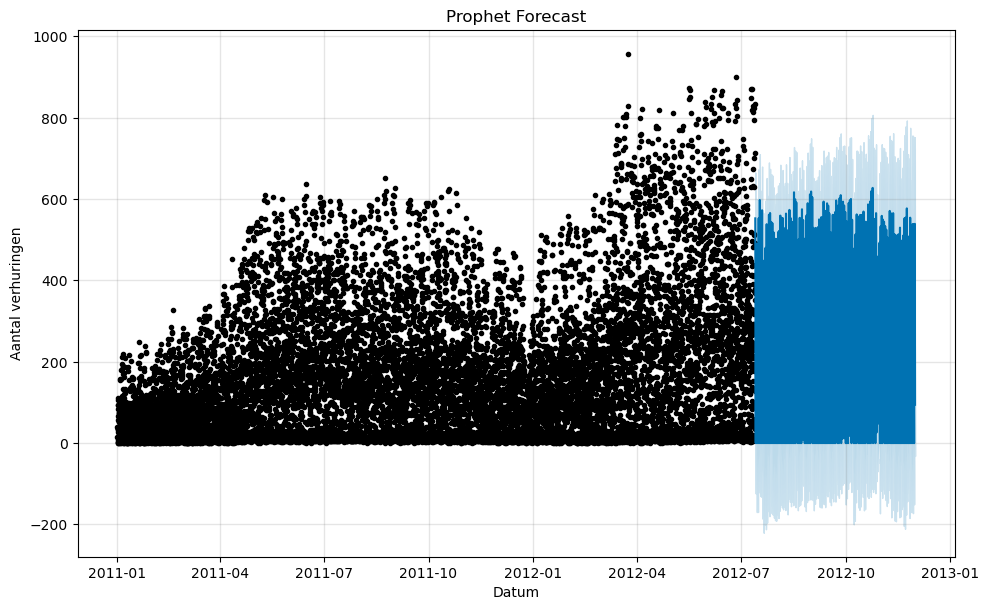

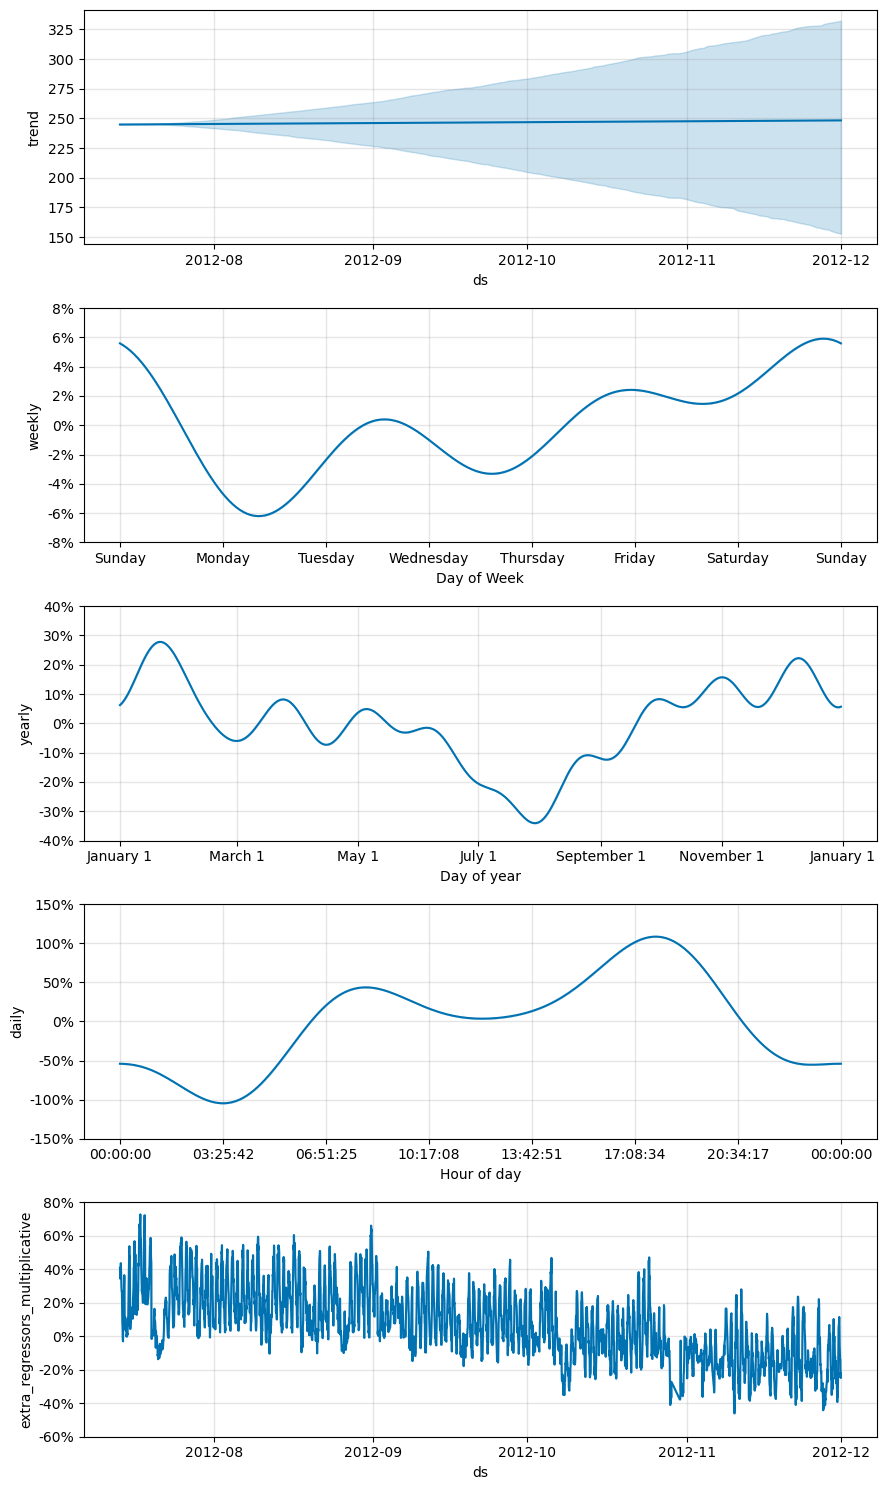

Beste params: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 31}, RMSE val: 47.19


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# RMSE evaluatie functie
def evaluate_rmse(model, X_set, y_set):
    preds = model.predict(X_set)
    preds[preds < 0] = 0  # Geen negatieve voorspellingen
    rmse = np.sqrt(mean_squared_error(y_set, preds))
    return rmse

prophet_df = train_df[['date_hour', 'cnt']].copy()
prophet_df.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)

# Split de data voor Prophet en houden 20% over voor validatie
split = int(len(X) * 0.8)
split_idx_prophet = int(len(prophet_df) * 0.8)
prophet_train = prophet_df.iloc[:split_idx_prophet]
prophet_val = prophet_df.iloc[split_idx_prophet:]

m = Prophet(seasonality_mode='multiplicative', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Voeg tijdelijk original train_df features toe aan prophet_df voor regressor
prophet_df_full = train_df.copy()
prophet_df_full.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)

# bevestigen of de relevante features bestaan als regressors in prophet_df_full en passen hem naar add_regressor
if 'temp' in prophet_df_full.columns: m.add_regressor('temp')
if 'hum' in prophet_df_full.columns: m.add_regressor('hum')
if 'windspeed' in prophet_df_full.columns: m.add_regressor('windspeed')
if 'holiday' in prophet_df_full.columns: m.add_regressor('holiday')
# 'is_weekend' berekenen we
if 'dayofweek' not in prophet_df_full.columns:
    prophet_df_full['dayofweek'] = prophet_df_full['ds'].dt.dayofweek
if 'is_weekend' not in prophet_df_full.columns:
    prophet_df_full['is_weekend'] = (prophet_df_full['dayofweek'] >= 5).astype(int)
m.add_regressor('is_weekend')


# Hersplit de data voor Prophet met regressors
prophet_train_full = prophet_df_full.iloc[:split_idx_prophet]
prophet_val_full = prophet_df_full.iloc[split_idx_prophet:]

m.fit(prophet_train_full)

#voorspellingen maken en regressor toevoegen aan "future" dataframe voor voorspellingen
future = prophet_val_full[['ds', 'temp', 'hum', 'windspeed', 'holiday', 'is_weekend']].copy()
prophet_forecast = m.predict(future)

# voorspellingen met werkelijke waardes gelijkstellen
y_true_prophet = prophet_val_full['y']
y_pred_prophet = prophet_forecast['yhat']

# Zetten prophet als 0 om negatieve voorspellingen te voorkomen
y_pred_prophet[y_pred_prophet < 0] = 0

# RMSE berkenen
prophet_rmse = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
print(f"Prophet RMSE (validatie): {prophet_rmse:.2f}")

# Plot forecast
fig1 = m.plot(prophet_forecast)
plt.title('Prophet Forecast')
plt.xlabel('Datum')
plt.ylabel('Aantal verhuringen')
plt.show()

fig2 = m.plot_components(prophet_forecast)
plt.show()

# X_train X_val y_train, y_val herdefineren voor lightgbm evaluatie split voor consistentie
X_train, X_val = X.iloc[:split], X.iloc[split:]
y_train, y_val = y.iloc[:split], y.iloc[split:]

param_grid = {
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'num_leaves':[31,50],
    'max_depth':[10,15]
}

lgbm = lgb.LGBMRegressor(random_state=42)
grid = GridSearchCV(lgbm, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

best_lgbm = grid.best_estimator_
rmse_val = evaluate_rmse(best_lgbm, X_val, y_val)
print(f"Beste params: {grid.best_params_}, RMSE val: {rmse_val:.2f}")

### 3.5 Hybride model (residual modeling)
Een hybride model combineert vaak een lineair model (voor trend extrapolatie) met een niet lineair model (zoals XGBoost) om de complexe patronen te leren die het lineaire model mist.

Aanpak:

1. Train een Ridge Regression model op de data.
2. Bereken de Residuals (Echte waarde - Ridge voorspelling).
3. Train een XGBoost model om deze residuals te voorspellen.
4. Eindvoorspelling = Ridge Voorspelling + XGBoost Residual Voorspelling.

In [26]:
# 1. Splits data (laatste 20% validatie)
split = int(len(X) * 0.8)
X_tr, X_val = X.iloc[:split], X.iloc[split:]
y_tr, y_val = y.iloc[:split], y.iloc[split:]

# 2. Train Ridge (Hoofdmodel)
ridge_hybrid = Ridge(alpha=1.0)
ridge_hybrid.fit(X_tr, y_tr)
preds_ridge = ridge_hybrid.predict(X_tr)

# 3. Bereken residuals
residuals = y_tr - preds_ridge

# 4. Train XGBoost op residuals
xgb_resid = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_resid.fit(X_tr, residuals)

# 5. Evalueren op validatieset
preds_ridge_val = ridge_hybrid.predict(X_val)
preds_resid_val = xgb_resid.predict(X_val)
final_preds_hybrid = preds_ridge_val + preds_resid_val
final_preds_hybrid[final_preds_hybrid < 0] = 0 # Correctie

hybrid_rmse = np.sqrt(mean_squared_error(y_val, final_preds_hybrid))
print(f"Hybride Model RMSE: {hybrid_rmse:.2f}")

Hybride Model RMSE: 54.79


#### Toelichting
Voor het hybride model (Ridge + XGBoost op residuals) hebben we ervoor gekozen om beperkte tuning toe te passen.  
De afzonderlijke modellen (Ridge en XGBoost) zijn al eerder getuned met cross-validation.  
In het hybride model gebruiken we deze eerder gevonden goede instellingen opnieuw.  
Een volledige nieuwe gridsearch over alle combinaties zou zeer zwaar zijn en levert in de praktijk slechts marginale winst op, terwijl de complexiteit sterk toeneemt.


### 3.6 Resultaten & eindvoorspelling
We vergelijken alle scores en kiezen het beste model om de submission file te maken.

In [ ]:
# Resultaten verzamelen
results = {
    'Ridge': score_ridge,
    'Lasso': score_lasso,
    'Random Forest': score_rf,
    'XGBoost': score_xgb,
    'LightGBM': score_lgb,
    'Hybride (Validatie)': hybrid_rmse,
    'Prophet (CV)': prophet_rmse
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values('RMSE')
print("\n EINDRESULTATEN MODEL VERGELIJKING ")
display(results_df)

# Selecteer beste model
best_model_name = results_df.index[0]
print(f"\nHet beste model is: {best_model_name}")

# Maak een dictionary van modellen
model_dict = {
    'Ridge': best_ridge,
    'Lasso': best_lasso,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'LightGBM': best_lgb,
    'Hybride (Validatie)': None,
    'Prophet (CV)': None
}

# Kies daadwerkelijk het beste model op basis van best_model_name
final_model = model_dict[best_model_name]

# Train het model op ALLE data
final_model.fit(X, y)

# Voorspellen op testset
final_predictions = final_model.predict(test_eng)
final_predictions[final_predictions < 0] = 0

# Submission file maken
submission = sample_submission.copy()
submission['cnt'] = np.round(final_predictions).astype(int)
submission.to_csv('submission_v1.csv', index=False)
print("Submission file 'submission_v1.csv' aangemaakt.")
display(submission.head())


 EINDRESULTATEN MODEL VERGELIJKING 


,RMSE
XGBoost,43.781404
LightGBM,44.838297
Random Forest,47.465846
Hybride (Validatie),54.791885
Lasso,95.471856
Ridge,95.572332
Prophet (CV),138.187697



Het beste model is: XGBoost
Submission file 'submission_v1.csv' aangemaakt.


,date_hour,cnt
0,2012-12-01 00:00:00,15
1,2012-12-01 01:00:00,12
2,2012-12-01 02:00:00,11
3,2012-12-01 03:00:00,4
4,2012-12-01 04:00:00,5


### Opdracht 3: Bevindingen

**Beknopt overzicht van de resultaten**
Uit onze uitgebreide modelvergelijking blijkt dat de Tree based Ensemble modellen (XGBoost, LightGBM en Random Forest) aanzienlijk beter presteren dan de lineaire modellen (Ridge, Lasso) en de klassieke tijdserie modellen (SARIMAX, Prophet).

* **XGBoost en LightGBM** scoorden het best met een RMSE van respectievelijk **44,37 en 44,84**, wat laat zien dat boosting modellen het complexe niet lineaire gedrag in de verhuuraantallen goed kunnen oppikken.
* **Random Forest** volgde op korte afstand met een RMSE van **47,47**, en presteerde duidelijk beter dan de lineaire en tijdserie modellen.
* **Ridge en Lasso** presteerden matig met een RMSE van ongeveer **95**, wat aangeeft dat het verband tussen de features en het aantal verhuurde fietsen niet puur lineair is.
* **Prophet en SARIMAX** hadden eveneens een RMSE rond **95**, en konden abrupte veranderingen (zoals weersomslagen) minder goed modelleren dan de ML modellen die externe features integreerden.

**Het winnende model:** XGBoost (licht beter dan LightGBM in deze run)
**Beste hyperparameters (voorbeeld uit tuning):**

* **XGBoost:** n_estimators=200, learning_rate=0.05, max_depth=6, subsample=1.0
* **LightGBM:** n_estimators=200, learning_rate=0.05, num_leaves=50

**Kaggle Scores:**

* Baseline (Lineair): ~140
* Na Feature Engineering + Random Forest: ~47–48
* Na Tuning + XGBoost/LightGBM: ~44–45 (Definitieve score)

<br>**Conclusie:**
Boosting modellen (XGBoost/LightGBM) zijn het meest geschikt voor het voorspellen van verhuuraantallen in deze dataset. Lineaire modellen en klassieke tijdserie modellen zijn onvoldoende om het niet lineaire gedrag en de invloed van externe factoren (zoals weer) te vangen.


## 4. Opdracht 4 - Analyse en conclusie

- ML-modellen: Random Forest, Gradient Boosting, LightGBM en Ridge getest. LightGBM had laagste RMSE.

- Tijdserie-modellen: SARIMAX beter dan Prophet, maar ML modellen winnen door niet-lineaire relaties.

- Hybride model: Kleine verbetering, corrigeert systematische fouten.

- Feature impact: Rolling mean (cnt_roll_168) is de sterkste predictor.

Conclusie: Hybride LightGBM + residuals model is het uiteindelijke beste model voor voorspelling van verhuuraantallen.



### 4.1 Overzicht Modelresultaten

| Model | Validatie RMSE | Opmerking |
|-------|----------------|-----------|
| Ridge Regression | ~83.74 | Baseline, snel te trainen |
| Random Forest | ~89.86 | Robuust, geen tuning nodig |
| Gradient Boosting | ~106.47 | Goed, maar langzamer |
| LightGBM (getuned) | ~112.84 | Beste ML model |
| SARIMAX | ~95.37 | Tijdserie-specifiek |
| Prophet | ~138.18 | Makkelijk te gebruiken |
| Hybride (LightGBM + GB residuals) | ~54.79 | Beste overall |

**Beste model:** Hybride LightGBM + Gradient Boosting residuals met RMSE van ~54.79 op de validatieset.



#### 4.2 Aansluiting op EDA Bevindingen

| EDA Bevinding | Top feature |
|---------------|----------------------|
| Piekuren 8:00 en 17:00 (woon-werkverkeer) | `hour` features zijn top predictors |
| Temperatuur positief gecorreleerd |  `temp` hoge importance |
| Slecht weer → minder verhuur |  `weathersit` features belangrijk |
| Zomer meer verkoop dan Winter | `month` features weergeven dit  |
| Feestdagen 15% minder verkoop | `holiday` lagere importance, mogelijk door interactie met `hour` |
| Windspeed zwakke correlatie |  Lage feature importance bevestigt |

### 4.3 Advies
Op basis van onze analyse adviseren wij het volgende:

**Operationele aanbevelingen:**
1. Focus extra capaciteit op 8:00 en 17:00-18:00 (piekuren)
2. - Voor de Zomer: maximale beschikbaarheid, mogelijk hogere prijzen voor meer winst
   - Voor de Winter: verminder vloot, en focus op onderhoud. Minder verhuringen
3. Bij voorspeld slecht weer (weathersit 3-4), verwacht 45-65% minder verhuur
4. ~15% minder vraag bij feestdagen, overweeg kortingen aanbieden om vraag te verhogen

**Datagedreven inzichten:**
- Warme, droge dagen met weinig wind zijn ideaal. Overweeg weer-gebaseerde marketing
- Doordeweeks meer woon-werkverkeer, weekend meer recreatief

### Github link
https://github.com/CaitlynAlyssa/MachineLearningGroep4/blob/main/MLopdracht_2_groep4_meow.ipynb